<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classification of Reddit Posts

# Problem Statement

<a id='problem_statement'></a><font color='lightpurple'> As part of the data analytics team in Zoom, we have been tasked with analysing discussions on Zoom and Microsoft Teams (MST) sub-Reddits. We will employ Natural Language Processing (NLP) techniques and train a machine learning model in a supervised fashion to classify submissions belonging to either sub-Reddits. As the model will use the content of the Reddit posts to perform classification, we can then use the insights derived from the model to determine the content that is correlated with Zoom and MST. From there, we will make two-pronged recommendations - to the software development team (SDT) and the marketing team (MT):
    
- </a><font color='lightpurple'>For the SDT, we will highlight common issues faced by users as well as any wishlist features that our users would like to see.
- </a><font color='lightpurple'>For the MT, we will examine features that MST users have issues with (more than Zoom users) and recommend to tweak the advertising strategy to capitalise on their perceived weaknesses. Secondly, we will also recommend to use words closely associated with Zoom and MST to be considered for our Search Engine Marketing and Search Engine Optimisation campaigns. Lastly, we can also utilise these words as paid keywords such as Google AdWords or organic keywords in our sites.   
    
<font color='lightpurple'> Success of the model will be evaluated via simple accuracy score, by calculating the proportion of predictions it got correct. Accuracy is sufficient for our problem as we will sample an equal number of posts from both sub-Reddits. Furthermore, both classes are equally important (ie. wrongly predicting the Zoom sub-Reddit is equally bad as wrongly predicting the MST sub-Reddit). A secondary layer of success evaluation would be the model's confidence - how confident it is at making predictions. In other words, we want to be sure that the model is not simply guessing the labels by chance. Otherwise, this may result in volatile results when performing on unseen data.

# Background

<img src="Charts/27.jpg" style="height: 400px; width:450px;">

<a id='background'></a><font color='lightpurple'> MST is our largest and fastest growing competitor in the videoconferencing industry. In a world terrorized by COVID-19, companies worldwide scramble to put together business continuity plans which enabled employees to continue working and operations to continue functioning in the midst of movement restrictions.
    
<font color='lightpurple'> Reddit is a network of communities where people can dive into their interests, hobbies and passions. There currently exists a sub-Reddit for Zoom (27k members) and another for MST (37k members). People can talk about literally anything under the sun, though in teh context of our chosen sub-Reddits, the content is usually centred around seeking advice for technical issues.
    
<font color='lightpurple'> In this project, we will explore the following NLP techniques:
- <font color='lightpurple'> TFIDFVectorizer
- <font color='lightpurple'> Word2Vec
- <font color='lightpurple'> BERT
    
<font color='lightpurple'> The following supervised learning models will also be tested for their ability to classify the Reddit posts:
- <font color='lightpurple'> RandomForestClassifier
- <font color='lightpurple'> LogisticRegression
- <font color='lightpurple'> MultiLayer Perceptron Classifier    
    
<font color='lightpurple'> The broad data pipeline is as follows:
    
<img src="Charts/26.jpg" style="height: 500px; width:500px;">     

##### Is it clear what the goal of the project is?

See [here](#problem_statement)

##### What type of model will be developed?

See [here](#problem_statement) and [here](#background)

##### How will success be evaluated?

See [here](#problem_statement). Also see [here](#model_evaluation) for actual results.

##### Is the scope of the project appropriate?

See [here](#problem_statement)

##### Is it clear who cares about this or why this is important to investigate?

See [here](#problem_statement)

##### Does the student consider the audience and the primary and secondary stakeholders?

<font color='lightpurple'> See [here](#problem_statement)

# Data Collection

In [94]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time
import spacy
from wordcloud import WordCloud, STOPWORDS
import re
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
import datetime
import random
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from gensim.models.fasttext import FastText
from gensim.models.keyedvectors import KeyedVectors
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

#nlp = spacy.load("en_core_web_lg")
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [17]:
# set parameters
params_zoom = {
    'subreddit': 'zoom',
    'size': 100,
    'after': 1577836800 # after 1 Jan 2020
}

url = 'https://api.pushshift.io//reddit/search/submission'

# get first tranche of data in a list. This retrieves the earliest 100 submissions
res_zoom = requests.get(url, params_zoom)
res_data_zoom = res_zoom.json()['data']

res_data_zoom_add = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 submissions
while len(res_data_zoom_add) > 0:
    time.sleep(2)
    params_zoom['after'] = res_data_zoom[-1]['created_utc']
    res_data_zoom_add = requests.get(url, params_zoom).json()['data']
    res_data_zoom += res_data_zoom_add

In [18]:
# save results to csv
pd.DataFrame(res_data_zoom).to_csv('datasets/zoom_s.csv', index=False)
print(pd.DataFrame(res_data_zoom).shape)

(14794, 87)


In [20]:
# set parameters
params_zoom = {
    'subreddit': 'zoom',
    'size': 100,
    'after': 1577836800 # after 1 Jan 2020
}

url_c = 'https://api.pushshift.io//reddit/search/comment'

# get first tranche of data in a list. This retrieves the earliest 100 comments
res_zoom_c = requests.get(url_c, params_zoom)
res_data_zoom_c = res_zoom_c.json()['data']

res_data_zoom_add_c = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 submissions
while len(res_data_zoom_add_c) > 0:    
    time.sleep(2)
    params_zoom['after'] = res_data_zoom_c[-1]['created_utc']
    res_data_zoom_add_c = requests.get(url_c, params_zoom).json()['data']
    res_data_zoom_c += res_data_zoom_add_c

In [21]:
# save results to csv
pd.DataFrame(res_data_zoom_c).to_csv('datasets/zoom_c.csv', index=False)
print(pd.DataFrame(res_data_zoom_c).shape)

(44937, 51)


In [22]:
# set parameters
params_mst = {
    'subreddit': 'MicrosoftTeams',
    'size': 100,
    'after': 1577836800
}

# get first tranche of data in a list. This retrieves the earliest 100 submissions
url = 'https://api.pushshift.io//reddit/search/submission'

res_mst = requests.get(url, params_mst)
res_data_mst = res_mst.json()['data']

res_data_mst_add = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 submissions
while len(res_data_mst_add) > 0:    
    params_mst['after'] = res_data_mst[-1]['created_utc']
    res_data_mst_add = requests.get(url, params_mst).json()['data']
    res_data_mst += res_data_mst_add

In [23]:
# save results to csv
pd.DataFrame(res_data_mst).to_csv('datasets/mst_s.csv', index=False)
print(pd.DataFrame(res_data_mst).shape)

(12632, 91)


In [24]:
# set parameters
params_mst = {
    'subreddit': 'MicrosoftTeams',
    'size': 100,
    'after': 1577836800
}

# get first tranche of data in a list. This retrieves the earliest 100 comments
url_c = 'https://api.pushshift.io//reddit/search/comment'

res_mst_c = requests.get(url_c, params_mst)
res_data_mst_c = res_mst_c.json()['data']

res_data_mst_add_c = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 comments
while len(res_data_mst_add_c) > 0:    
    params_mst['after'] = res_data_mst_c[-1]['created_utc']
    res_data_mst_add_c = requests.get(url_c, params_mst).json()['data']
    res_data_mst_c += res_data_mst_add_c

In [25]:
# save results to csv
pd.DataFrame(res_data_mst_c).to_csv('datasets/mst_c.csv', index=False)
print(pd.DataFrame(res_data_mst_c).shape)

(61325, 52)


##### Was enough data gathered to generate a significant result?

<font color='lightpurple'> About 14k submissions from Zoom and 12k from MST were scraped. Their corresponding comments were also scraped to be used as additional features for the machine learning model. Subsequently, we will define the time period (1 Apr 2020 - 31 Mar 2021) based on exploratory data analysis and sample equal number of posts (about 7000 each) from each subreddit. See [here](#filter_time)

##### Was data collected that was useful and relevant to the project?

<font color='lightpurple'> Yes we scraped data from Reddit, which is the project requirement.

##### Was data collection and storage optimized through custom functions, pipelines, and/or automation?

<font color='lightpurple'> As scraping posts takes a considerable amount of time, our strategy is to first scrape all submissions and comments from a comprehensive time period (1 Jan 2020 till date) and store the raw data in a csv file. From here, reading csv files is much faster and subsequent text processing and experimentation can be performed from this csv files. It is also alot more convenient to identify project parameters such as the time period using EDA from csv files.

##### Was thought given to the server receiving the requests such as considering number of requests per second?

<font color='lightpurple'> Yes, to avoid jamming the server, a 2 second sleep time code was inserted between each round of scraping.

# Data Cleaning & EDA

In [23]:
# Read in raw data and perform some basic cleaning
zoom_c = pd.read_csv('datasets/zoom_c.csv', low_memory=False)
zoom_c = zoom_c[zoom_c['author']!= 'AutoModerator']
zoom_c = zoom_c[['created_utc', 'body', 'parent_id', 'subreddit']]
zoom_c['created_utc'] = zoom_c['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time
zoom_c['parent_id'] = zoom_c['parent_id'].str[3:] # used to join to submission id

mst_c = pd.read_csv('datasets/mst_c.csv', low_memory=False)
mst_c = mst_c[['created_utc', 'body', 'parent_id', 'subreddit']]
mst_c['created_utc'] = mst_c['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time
mst_c['parent_id'] = mst_c['parent_id'].str[3:] # used to join to submission id

zoom_s = pd.read_csv('datasets/zoom_s.csv', low_memory=False)
zoom_s = zoom_s[['id', 'created_utc', 'selftext', 'title', 'subreddit']]
zoom_s['created_utc'] = zoom_s['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time

mst_s = pd.read_csv('datasets/mst_s.csv', low_memory=False)
mst_s = mst_s[['id', 'created_utc', 'selftext', 'title', 'subreddit']]
mst_s['created_utc'] = mst_s['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time

<font color='lightpurple'> For the comment files, the following columns were retained:
- <font color='lightpurple'> created_utc: timestamp of post
- <font color='lightpurple'> body: content
- <font color='lightpurple'> parent_id: Unique Id of the submission under which the comment was posted. We will later on concatenate all comments per submission and join it to the original content of the submission.
- <font color='lightpurple'> subreddit: target variable for the classifier to predict on

<font color='lightpurple'> In addition, through a cursory glance through the Zoom subreddit I found that there are many bot posts under the author "AutoModerator". Since the content of these comments are identical and adds no value, we will remove such comments.

<font color='lightpurple'> For the submission files, the following columns were retained:
- <font color='lightpurple'> id: Unique Id of the submission, used to join the comments
- <font color='lightpurple'> created_utc: timestamp of post
- <font color='lightpurple'> selftext: Description and actual content of the submission
- <font color='lightpurple'> title: Title of submission
- <font color='lightpurple'> subreddit: target variable for the classifier to predict on

### Check for nulls

In [24]:
zoom_s.isnull().sum()

id                0
created_utc       0
selftext       2223
title             0
subreddit         0
dtype: int64

In [25]:
zoom_c.isnull().sum()

created_utc    0
body           0
parent_id      0
subreddit      0
dtype: int64

In [26]:
mst_s.isnull().sum()

id                0
created_utc       0
selftext       2211
title             0
subreddit         0
dtype: int64

In [27]:
mst_c.isnull().sum()

created_utc    0
body           0
parent_id      0
subreddit      0
dtype: int64

<font color='lightpurple'> Only the selftext columns have null values, which is fine because not all submissions have descriptions.

In [28]:
print(f'There is an average of {mst_c.groupby("parent_id")["body"].count().mean()} comments per submission for MST')
print(f'There is an average of {zoom_c.groupby("parent_id")["body"].count().mean()} comments per submission for Zoom')

There is an average of 1.5913691094041935 comments per submission for MST
There is an average of 1.5999021673690548 comments per submission for Zoom


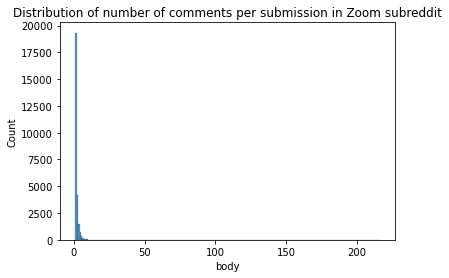

In [29]:
sns.histplot(data=zoom_c.groupby("parent_id")["body"].count().reset_index(), x='body', binwidth=1)
plt.title('Distribution of number of comments per submission in Zoom subreddit')
plt.savefig('Charts/09.jpg')

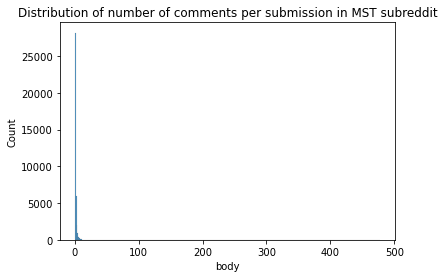

In [30]:
sns.histplot(data=mst_c.groupby("parent_id")["body"].count().reset_index(), x='body', binwidth=1)
plt.title('Distribution of number of comments per submission in MST subreddit')
plt.savefig('Charts/10.jpg')

<font color='lightpurple'> We can see that the majority of reddit submissions have less than 5 comments.

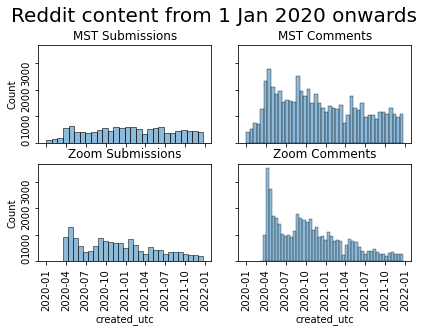

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.suptitle('Reddit content from 1 Jan 2020 onwards', size=20)
plt.tight_layout()
plt.xticks(rotation=90)

sns.histplot(mst_s['created_utc'], alpha=0.5, ax=ax[0,0])
ax[0,0].tick_params(labelrotation=90)
ax[0,0].title.set_text('MST Submissions')

sns.histplot(mst_c['created_utc'], alpha=0.5, ax=ax[0,1])
ax[0,1].tick_params(labelrotation=90)
ax[0,1].title.set_text('MST Comments')

sns.histplot(zoom_s['created_utc'], alpha=0.5, ax=ax[1,0])
ax[1,0].tick_params(labelrotation=90)
ax[1,0].title.set_text('Zoom Submissions')

sns.histplot(zoom_c['created_utc'], alpha=0.5, ax=ax[1,1])
ax[1,1].tick_params(labelrotation=90)
ax[1,1].title.set_text('Zoom Comments')

fig.savefig('Charts/01.jpg')

<a id='filter_time'></a><font color='lightpurple'> Based on the time series plot, we observe the following:
- <font color='lightpurple'> There are many more comments than submissions (obviously)
- <font color='lightpurple'> Content on both subreddits spiked from Apr 2020, which corresponds to the period where most countries go into high alert/lockdowns and interactions were shifted online
- <font color='lightpurple'> MST content was sustained throughout the 2 years while Zoom content dwindled over time after the initial spike

<font color='lightpurple'> For the purpose of analysis, we will limit the timeframe to 1 year starting from 1 Apr 2020, the period during which most relevant Reddit content would have been generated. 

In [32]:
# Filter time periods to between 1 Apr 2020 and 31 Mar 2021 + further cleaning

zoom_s = zoom_s[(zoom_s['created_utc'] >= '2020-04-01') & (zoom_s['created_utc'] <= '2021-03-31')]

# convert placeholders and NaN to blank string
zoom_s['selftext'] = zoom_s['selftext'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x) 
zoom_s['title'] = zoom_s['title'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x)

# replace \n with white space
zoom_s['selftext'] = zoom_s['selftext'].str.replace('\n', ' ')
zoom_s['title'] = zoom_s['title'].str.replace('\n', ' ')

# remove urls
zoom_s['selftext'] = zoom_s['selftext'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
zoom_s['title'] = zoom_s['title'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
zoom_s['text'] = zoom_s[['selftext', 'title']].agg(' '.join, axis=1)
zoom_s = zoom_s.drop(columns = ['selftext', 'title'])

# repeat for mst
mst_s = mst_s[(mst_s['created_utc'] >= '2020-04-01') & (mst_s['created_utc'] <= '2021-03-31')]
mst_s['selftext'] = mst_s['selftext'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x)
mst_s['title'] = mst_s['title'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x)
mst_s['selftext'] = mst_s['selftext'].str.replace('\n', ' ')
mst_s['title'] = mst_s['title'].str.replace('\n', ' ')
mst_s['selftext'] = mst_s['selftext'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
mst_s['title'] = mst_s['title'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
mst_s['text'] = mst_s[['selftext', 'title']].agg(' '.join, axis=1)
mst_s = mst_s.drop(columns = ['selftext', 'title'])

zoom_c = zoom_c[(zoom_c['created_utc'] >= '2020-04-01') & (zoom_c['created_utc'] <= '2021-03-31')]
mst_c = mst_c[(mst_c['created_utc'] >= '2020-04-01') & (mst_c['created_utc'] <= '2021-03-31')]

In [33]:
zoom_s.shape

(10727, 4)

In [34]:
mst_s.shape

(7006, 4)

In [35]:
# Choose 7006 rows at random from Zoom submission dataframe
random_integers = np.random.choice(range(0,10727), size=7006, replace=False).tolist()

zoom_s = zoom_s.sort_values('created_utc').reset_index(drop=True)
zoom_s = zoom_s.iloc[random_integers, :]
print(zoom_s.shape)

combined_s = pd.concat([zoom_s, mst_s]).reset_index(drop=True)
print(combined_s.shape)

# Dummify target variable
combined_s['subreddit'] = combined_s['subreddit'].map({'MicrosoftTeams': 0, 'Zoom': 1})

(7006, 4)
(14012, 4)


<a id='class_count'></a><font color='lightpurple'> The unbalanced classes (10727 Zoom vs 7006 MST) may result in the model not having sufficient data to predict the underrepresented class, hence we will randomly undersample the overrepresented class (Zoom) to ensure that the classes are equal. This will also allow the timeframe for each to be kept consistent. Each row will now correspond to a submission with all its corresponding comments. The total row count is the total number of zoom and MST submissions

<a id='basic_text_cleaning'></a><font color='lightpurple'> We first performed some basic text cleaning on the selftext and title columns such as:
- <font color='lightpurple'> Removing [deleted] and [removed] placeholders.
- <font color='lightpurple'> Replacing new line placeholders (\n) with blank space. This is so that words are not unnecessarily concatenated to each other
- <font color='lightpurple'> Removing URLs as these do not provide any useful information

<font color='lightpurple'> Comments are also filtered to within the same period so that comments on old posts are not taken into consideration. For example, a comment may be made in Jun 2021 on a submission in Jan 2021. This comment would be not considered. No text cleaning was also performed on the comments as we do not intend to use its text. Rather, we will aggregate the comments as additional features to be fed into the machine learning model, to reduce the number of dimensions.
    
<font color='lightpurple'> Advanced text cleaning methods such as removal of stopwords, punctuations, casing, lemmatization and stemming were not performed here as we intend to experiment on different methods of word vectorization. Depending on the method selected, we'll want to apply different levels of text cleaning. This will be elaborated further below under Preprocessing and Modeling.  
    
<font color='lightpurple'> The "selftext" and "title" columns are concatenated as users may post their content on either field. For example, one user may post "Help needed" as the title and the actual question in the selftext while another user may plonk the entire question in the title. Hence we concatenated both columns to avoid loss of information.    

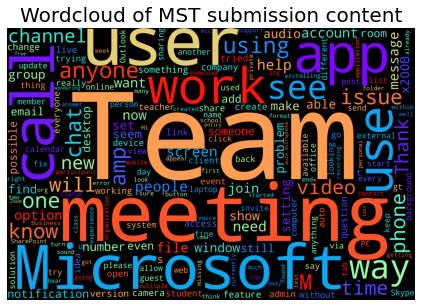

In [38]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(15, 5))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.title('Wordcloud of MST submission content', size=20)
    plt.savefig('Charts/02.jpg')
    
# Generate word cloud
#STOPWORDS.update(['media', 'omitted', 'im', 'image', 'omittedsticker', 'sticker', 'youre', 'omittedimage'])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='black', colormap='rainbow', collocations=False, 
                      stopwords = STOPWORDS).generate(mst_s['text'].str.cat())
# Plot
plot_cloud(wordcloud)

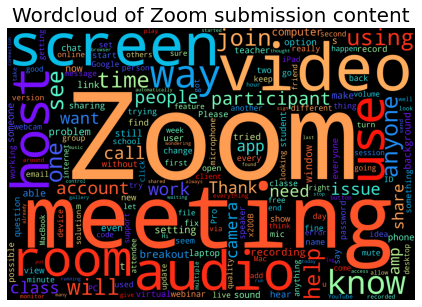

In [39]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(15,5))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.title('Wordcloud of Zoom submission content', size=20)
    plt.savefig('Charts/03.jpg')
    
# Generate word cloud
#STOPWORDS.update(['media', 'omitted', 'im', 'image', 'omittedsticker', 'sticker', 'youre', 'omittedimage'])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='black', colormap='rainbow', collocations=False, 
                      stopwords = STOPWORDS).generate(zoom_s['text'].str.cat())
# Plot
plot_cloud(wordcloud)

<font color='lightpurple'> Other than the product name, a cursory scan of both wordclouds indicate that some of the terminologies used are very similar, such as "meeting", "use". Some distinction in words include:
- <font color='lightpurple'> Host (Zoom)
- <font color='lightpurple'>Screen (Zoom)
- <font color='lightpurple'>App (MST)
- <font color='lightpurple'>Call (MST)

<font color='lightpurple'> Because the product name is so prominent, we can take advantage of these to summarise comments for each submission, rather than incorporating the text itself. Our text analytics will thus only focus on content from the submission.

### Feature Engineering

<font color='lightpurple'> Our text analytics will largely focus around the submission content, while the comments will be summarised and aggregated into simple numbers, thereby largely disregarding the comment's text.

<font color='lightpurple'> In addition to the word vectors we will generate later on for the submission content, we will also retain simple information from the comments. For each comment, we will calculate the following statistics:
    
|Column|Description|
|---|---|
|has_zoom|Whether the word "zoom" occurs (without "microsoft" or "teams")|
|has_mst|Whether the words "microsoft" or "teams" occur (without "zoom")|
|has_zoom_mst|Whether the comment has both "zoom" and either "microsoft" or "teams"|
|no_zoom_mst|Whether the comment has neither "zoom" nor "microsoft" nor "teams"|    
|char_count|Number of characters of comment|       

<font color='lightpurple'> With these statistics, we will further aggregate to the submission level. Each submission will have the following statistics: 
    
|Column|Description|
|---|---|
|prop_zoom|Proportion of comments that only have "zoom"|    
|prop_mst|Proportion of comments that only have "microsoft" or "teams"|    
|prop_zoom_mst|Proportion of comments that have "zoom" and either "microsoft" or "teams"|    
|prop_no_zoom_mst|Proportion of comments that has neither "zoom" nor "microsoft" nor "teams"|       
|avg_cmt_len|Average length of comments|     
|num_cmts|Number of comments|  

In [40]:
# Define custom function to check whether word(s) is/are in string
def check_word_in_string(s, list_of_words):    
    
    return any(word in s.lower() for word in list_of_words)
    
check_word_in_string('Make sure you have updated Zoom to the most current version.', ['zoom'])

True

In [41]:
combined_c = pd.concat([zoom_c, mst_c]).reset_index().drop(columns = ['index'])

combined_c['has_zoom'] = combined_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['has_mst'] = combined_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['has_zoom_mst'] = combined_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['no_zoom_mst'] = combined_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['char_count'] = combined_c['body'].apply(len)

#mst_c['has_zoom'] = mst_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['has_mst'] = mst_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['has_zoom_mst'] = mst_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['no_zoom_mst'] = mst_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['char_count'] = mst_c['body'].apply(len)

In [52]:
combined_c_groupby = combined_c.groupby(['subreddit','parent_id'])[['has_zoom', 'has_mst', 'has_zoom_mst', 'no_zoom_mst', 'char_count']].mean().reset_index()
combined_c_groupby['subreddit'] = combined_c_groupby['subreddit'].map({'MicrosoftTeams': 0, 'Zoom':1})

<font color='lightpurple'> In the combined_c_groupby dataframe, each row corresponds to the summary statistics of the comments for each submission. For example, in parent_id dwgdk1 (MST), we can say that 25% of the comments have MST tags only while 75% of the comments have neither zoom nor MST tags. Also, the average length of comment is 144.5 characters.
    
<font color='lightpurple'> This dataframe will be concatenated as extra features to the word vectors after vectorising the submission content later on.    

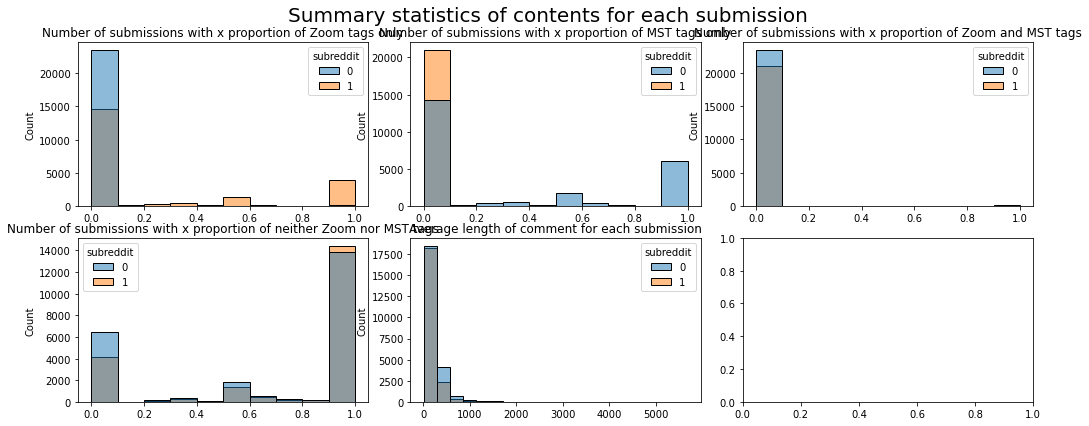

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (14,6))
fig.suptitle('Summary statistics of contents for each submission', size=20)
plt.tight_layout()

sns.histplot(data=combined_c_groupby, x='has_zoom', hue='subreddit', binwidth = 0.1, ax=ax[0,0])
ax[0,0].title.set_text('Number of submissions with x proportion of Zoom tags only')
ax[0,0].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='has_mst', hue='subreddit', binwidth = 0.1, ax=ax[0,1])
ax[0,1].title.set_text('Number of submissions with x proportion of MST tags only')
ax[0,1].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='has_zoom_mst', hue='subreddit', binwidth = 0.1, ax=ax[0,2])
ax[0,2].title.set_text('Number of submissions with x proportion of Zoom and MST tags')
ax[0,2].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='no_zoom_mst', hue='subreddit', binwidth = 0.1, ax=ax[1,0])
ax[1,0].title.set_text('Number of submissions with x proportion of neither Zoom nor MST tags')
ax[1,0].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='char_count', hue='subreddit', bins=20, ax=ax[1,1])
ax[1,1].title.set_text('Average length of comment for each submission')
ax[1,1].set_xlabel('')

fig.savefig('Charts/11.jpg')

In [44]:
combined_c_groupby.groupby('subreddit')[['has_zoom', 'has_mst', 'has_zoom_mst', 'no_zoom_mst', 'char_count']].mean()

,has_zoom,has_mst,has_zoom_mst,no_zoom_mst,char_count
subreddit,,,,,
0,0.007439,0.323562,0.009944,0.659056,202.545293
1,0.241470,0.003302,0.005198,0.750029,153.564988


<font color='lightpurple'> From the top left histogram, majority of the MST submissions have comments which do not contain Zoom tags only. On the other hand, there are about 3000 Zoom submissions which have a large proportion of their comments with Zoom tags only.
    
<font color='lightpurple'> As the histograms are not so interpretable, averaging the proportions might be more meaningful as we can see in the summary table above. We see that for MST, on average, 32% of the comments for each submission contains MST tags only, while 66% of the comments do not mention either Zoom or MST. For Zoom, on average, 24% of the comments for each submission contains Zoom tags only, while 76% of the comments do not mention either Zoom or MST. The average comment length is also higher for MST as compared to Zoom.
    
<font color='lightpurple'> In other words, we can postulate that given a particular submission, if a higher proportion of its comments are geared toward a certain tag, it is more likely that the submission is from that subreddit. This is of course, a no-brainer, but  we can see that 'has_zoom' and 'has_mst' might be potentially useful features in our machine learning model. We will proceed to drop the other 3 features since they do not show obvious distinctions in distribution vis-a-vis the 2 subreddits and are unlikely to be useful.

In [45]:
combined_c_groupby.drop(columns=['has_zoom_mst', 'no_zoom_mst', 'char_count'], inplace=True)

### Has the submission content changed over time?

In [46]:
# Do word count for top 10 words in Zoom and MST submissions via manual tokenizing

# manual tokenizing on space and punctuation and remove stopwords.
combined_s['text_nostop'] = combined_s['text'].apply(lambda x: ' '.join([i for i in RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(x) if i.lower() not in stopwords.words('english')]))

# 1. Filter to respective month and subreddits
# 2. Extract text_nostop column and string concatenate all rows into one long string
# 3. Tokenize into list of words
apr_zoom_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 4) & (combined_s['subreddit'] == 1)]['text_nostop'].str.cat())
dec_zoom_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 12) & (combined_s['subreddit'] == 1)]['text_nostop'].str.cat())

apr_mst_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 4) & (combined_s['subreddit'] == 0)]['text_nostop'].str.cat())
dec_mst_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 12) & (combined_s['subreddit'] == 0)]['text_nostop'].str.cat())

# String all content together, then tokenize with space as separator
#words_zoom = RegexpTokenizer('\s+', gaps=True).tokenize(combined_s[combined_s['subreddit'] == 1]['text'].str.cat())

# Remove stopwords
#words_zoom_nostop = [i for i in words_zoom if i.lower() not in stopwords.words('english')]

#words_mst = RegexpTokenizer('\s+', gaps=True).tokenize(combined_s[combined_s['subreddit'] == 0]['text'].str.cat())
#words_mst_nostop = [i for i in words_mst if i.lower() not in stopwords.words('english')]

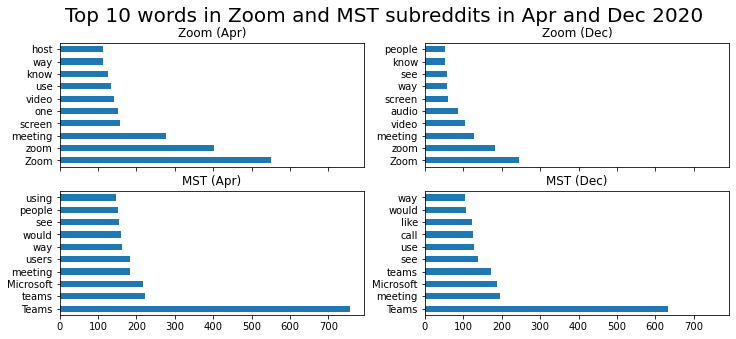

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,5), sharex=True)
plt.suptitle('Top 10 words in Zoom and MST subreddits in Apr and Dec 2020', size=20)

# Use Counter to count number of occurrences of each word, then put results in a dictionary, then a Series
# Sort the series by word count and take the top 10 most occurring
pd.Series(dict(Counter(apr_zoom_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[0,0])
ax[0,0].title.set_text('Zoom (Apr)')
pd.Series(dict(Counter(dec_zoom_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[0,1])
ax[0,1].title.set_text('Zoom (Dec)')
pd.Series(dict(Counter(apr_mst_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[1,0])
ax[1,0].title.set_text('MST (Apr)')
pd.Series(dict(Counter(dec_mst_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[1,1])
ax[1,1].title.set_text('MST (Dec)')

fig.savefig('Charts/05.jpg')

<font color='lightpurple'> Based on the top 10 words, there does not seem to be a major change in discussion content between Apr and Dec, for both Zoom and MST subreddits

In [49]:
# Save cleaned data as csv
combined_s[['id', 'created_utc', 'subreddit', 'text', 'text_nostop']].to_csv('datasets/cleaned_submission.csv', index=False)
combined_c_groupby.to_csv('datasets/cleaned_comments.csv', index=False)

##### Are missing values imputed/handled appropriately?

<font color='lightpurple'> Since we are mainly using text as predicting features, we will only use submissions with at least some text within. Null rows or rows with blank strings/spaces (after text cleaning) are dropped.

##### Are distributions examined and described?

<font color='lightpurple'> Yes, wordclouds were employed as a "fun" way to visualise common words. Word count barcharts were employed to observe any significant shifts in language over time. Lastly, statistics on comments were also explored to see if comments could be use as potential distinguishing features between Zoom and MST sub-reddits/

##### Are outliers identified and addressed?

<font color='lightpurple'> Since it is not practical to quantify text data in the same manner we would numerical data, we are not able to confidently define what is considered an outlier. The only "outliers" removed were null or blank submissions.

##### Are appropriate summary statistics provided?

<font color='lightpurple'> We provided a count of each class (Zoom vs MST) (see [here](#class_count)) as well as statistics on the comments per submission as well as top 10 word count barcharts for each subreddit. As the project focussed on examining text data and using its content as features (rather than say its length), it is impractical to provide summary statistics. 

##### Are steps taken during data cleaning and EDA framed appropriately?

<font color='lightpurple'> As the data cleaning steps for different NLP technique might differ, we are only able to perform basic text cleaning at the start. (see [here](#basic_text_cleaning)) More details on this is provided right below in the next section on Preprocessing and Modeling

##### Does the student address whether or not they are likely to be able to answer their problem statement with the provided data given what they've discovered during EDA?

<font color='lightpurple'> Based on our EDA so far, even with stopwords removed, it is difficult to tell if the content would be sufficient to adequately differentiate the two subreddits. There are however, some telling signs such as the presence of Zoom or MST tags. Based on this, it would seem that vectorizers such as Count or Tfidf would do well here.
    
<font color='lightpurple'> We will also continue to perform EDA after we vectorize our text and use the information to help us gauge whether our model is going to do well for our problem statement.
    
- [PCA analysis of Word2Vec word vectors](#pca_w2v)
- [AgglomerativeClustering of BERT word vectors](#ac_bert1)    
- [Visualising of BERT and Word2Vec word vectors with t-SNE](#tsne1)    
    
<font color='lightpurple'> Performing these clustering and dimensionality reduction techniques provide us with a sense of how the data is distributed. If there are clear clusters, we can then speculate that our  model will likely do well.    

# Preprocessing & Modeling

<a id='advanced_text_cleaning'></a><font color='lightpurple'> In order for machine learning to be applied to text, the text needs to be first converted into numbers, a process known as vectorisation. There are many different ways of vectorisation ranging in terms of complexity.
    
<font color='lightpurple'> In this project, we will explore 3 different vectorisation methods and see which produces the best results. These are:
- <font color='lightpurple'> TfidfVectorizer    
- <font color='lightpurple'> Word2Vec
- <font color='lightpurple'> BERT 
    
<font color='lightpurple'> We will also test 2 different machine learning models to see which is able to best distinguish the subreddit contents. These are:
- <font color='lightpurple'> LogisticRegression
- <font color='lightpurple'> RandomForest
- <font color='lightpurple'> MultiLayer Perceptron Classifier    
    
<font color='lightpurple'> Because of the differences in how the 3 word vectorizers vectorisers the text, we need to perform further text cleaning in different ways, such as deciding whether to remove stopwords and/or lemmatize the text. When performing text analytics, it is important to ensure that words of similar meanings are grouped together to avoid duplication, as in the case of 'run', 'ran', 'running'. Two popular methods are Porter Stemmer and Lemmatization. Both methods attempt to return a given word to its root word, or lemma, but does so in a different way. It is also worth noting that neither are able to correct spelling errors. This might throw our model off if such errors occur in large quantities.

<font color='lightpurple'> Porter Stemmer is a rule-based method that removes word prefixes and suffixes in a pre-determined fashion. It is fast, although the resulting word may not be an english word. For example, stemming 'computer' results in 'comput'. It is also rather blunt, as stemming 'computation' also results in 'comput', although both words might have different meanings. Lemmatization on the other hand, is a softer approach and takes the context of the word into account. However, it is computationally more expensive. As we want our model to be as accurate and interpretable as possible, we will go with lemmatization instead where appropriate.
    
<font color='lightpurple'> **TfidfVectorizer** is an improvement over the standard CountVectorizer, where the occurrence of a word in the document is compared to its occurrences over the whole corpus. For example, if the word 'computer' occurs frequently in Zoom submissions but doesn't occur again elsewhere, we can say that 'computer' is likely to be very important to that sub-reddit. On the other hand, words like 'that' are generic and probably occur in every document, hence less weightage will be assigned to this word. The mathematical formula to calculate Tfidf is such that the resulting value might be a decimal, and the resulting dataframe has the same number of rows as the number of submissions, and the number of columns equal to the number of unique words. As such, the following preprocessing will need to be applied when using TfidfVectorizer:
- <font color='lightpurple'> Removal of punctuation, special characters and stopwords: These add no value to the overall meaning of the document. While the formula of Tfidf would already neglect these items naturally, it would be good to remove them anyway.
- <font color='lightpurple'> Lemmatization: Since the vectorizer does not take into account the meaning of the word, we'll need to group similar words together via Lemmatization to avoid duplication of words of similar meanings.     
- <font color='lightpurple'> Casing: Word casings should be standardized to lower case to avoid duplication of words with similar meanings (eg. run vs RUN)   
    
<font color='lightpurple'> **Word2Vec** is a more advanced technique at deciphering word meanings and seeks to decompose every word into an n-dimensional array, such that words of similar meaning would be close together in n-dimensional space. Sentences can then be aggregated by taking the average of the arrays of the individual words. It employs a "bag-of-words" model, which means that two sentences which are in complete reverse in order would also end up with the same aggregated vector, which sounds odd. However, in practice, this method still works relatively well despite this theoretical drawback. The process of assigning vectors to each word is done by using a pre-trained model [(link)](https://github.com/RaRe-Technologies/gensim-data) which has trained on a Google news dataset containing 100 billion words. Since the language is the same (English) and the use of language is not significantly different from the Google news dataset, using the pre-trained model would save us hundreds of hours of training time without sacrifice in accuracy. A disadvantage of Word2Vec is that unusual words and spelling errors cannot be recognised and have to be manually removed prior to vectorisation. It is also unaware of the context, such as 'bank' as in a financial bank vs a river bank. The aforementioned pre-trained model decomposes words into 300-D arrays and as such, our resulting dataframe would have the same number of rows as the number of submissions, and 300 columns. We will apply the following preprocessing method for Word2Vec:
- <font color='lightpurple'> Removal of punctuation, special characters and stopwords: As these do not add meaning to the sentence, having them would dilute the overall meaning of the sentence. Hence we should remove these.
- <font color='lightpurple'> Lemmatization: Words such as 'run' and 'ran', though similar, will have slightly different vectors which may contribute to the overall meaning of the sentence. For this project, we will not lemmatize the text to retain its original meaning.
- <font color='lightpurple'> Casing: This is abit of a double-edged sword where casing can both help and hurt in determining the overall meaning of the sentence. For example, in this model, 'zoom' and 'Zoom' are recognised differently, with the model being able to pick up the fact that the latter is the videoconferencing platform. Standardising casing would lose this distinction. On the other hand, typo errors such as 'zooM' would cause the model to be completely unable to recognise the word and force us to discard it. For this project, we will retain the original casing as it is more important that the true meaning is captured.
    
<font color='lightpurple'> **BERT** is an even more advanced method to vectorize text. BERT is able to take the entire sentence, stopwords and punctuation together and figure out its context of every single word. Hence, the 'bank' in financial banks and river banks would have different vector arrays. For this project, we will use DistilBert, a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances. We will also use the pre-trained model 'distilbert-base-uncased' to save us training time, as we did for Word2Vec. The output of DistilBert is an M x N x 768-dimension array, where M is the number of docments and N is the number of tokens. We will be using the inbuilt [CLS] token as the document average vector (other methods involve averaging the word vectors as in Word2Vec, or taking the weighted average by Tfidf). Because BERT is context-dependent, we will not perform any further preprocessing for this, to avoid confusing the model.    

||TfidfVectorizer|Word2Vec|BERT|
|---|---|---|---|
|Removal of punctuation, special characters and stopwords|Y|Y|N|
|Lemmatization|Y|N|N|
|Standardised casing|Y|N|N|

### Process submission text for each vectoriser separately

In [2]:
lemmatizer = WordNetLemmatizer()

cmts = pd.read_csv('datasets/cleaned_comments.csv')[['parent_id', 'has_zoom', 'has_mst']]

df = pd.read_csv('datasets/cleaned_submission.csv')
df = df.dropna(subset=['text_nostop']).reset_index().drop(columns='index')
df.columns = ['ids', 'created_utc', 'subreddit', 'text', 'text_nostop'] # as tfidf count also has the word 'id'
df = df[df['text'] != ' ']

### TfidfVectorizer

In [3]:
def preprocess_tfidf(dataframe,
                     lower_case=True,
                     remove_special_punc=True,
                     lemmatize=True):
    '''
    Takes in a dataframe including the text, performs text preprocessing and returns the dataframe
    '''
    
    # Preprocess text first
    df_tfidf = dataframe[['subreddit', 'text_nostop']]
    df_tfidf.columns = ['subreddit', 'text_nostop']
    
    if lower_case:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.lower() #lower case
    
    if remove_special_punc:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation
    
    if lemmatize:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()])) #lemmatize
        
    return df_tfidf

### Word2Vec

In [4]:
# once-off download
#w2v = api.load("word2vec-google-news-300")

# Once off save model

#w2v.save('models/word2vec')

In [104]:
w2v = KeyedVectors.load('models/word2vec')

### Visualising Word2Vec word vectors

<font color='lightpurple'> It is difficult for us to visualise a vector space of 300 dimensions to get a sense of how "close" words are, but we can employ Principle Component Analysis (PCA) to decompose the 300 dimensions into the 2 principle components such that we can view it in 2-d space. PCA is a linear dimensionality reduction technique that strives to preserve as much information as possible within a fewer number of dimensions. It is useful for feature reduction and visualising high dimension data, but the downside is that the resulting features are no longer interpretable. There is also no need to scale the data as Word2Vec already puts the vectors in the same scale.
    
<font color='lightpurple'> We have chosen the top 10 words from the earlier word count (manual) in Zoom and MST subreddits to see if these words can be distinguish properly and hence provide some clue as to how successful our model may be.

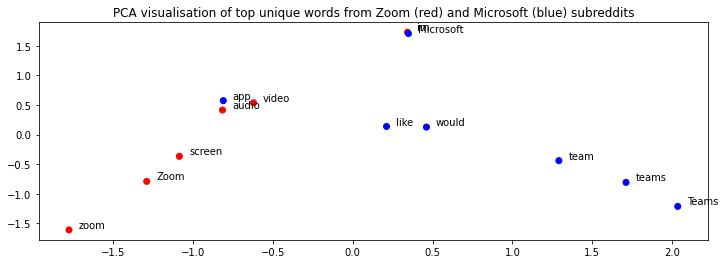

In [11]:
from sklearn.decomposition import PCA

# 14 unique words that only appear in either Zoom or MST
zoom_mst_words = ['Zoom', 'zoom', 'screen', 'video', 'audio', 'im', 'teams', 'Microsoft', 'app', 'would', 'team', 'like', 'Teams']

word_vectors = w2v[zoom_mst_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 4))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=['red']*6 + ['blue']*7)
plt.title('PCA visualisation of top unique words from Zoom (red) and Microsoft (blue) subreddits')

for word_names, x, y in zip(zoom_mst_words, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')
    
plt.savefig('Charts/08.jpg')    

<a id='pca_w2v'></a><font color='lightpurple'> Well how about that! We can see that the distinction between the words from Zoom subreddit and words from MST subreddit are quite nicely divided, with the exception of "app" and "im". This is indeed a promising sign that the content between the 2 subreddits are distinct enough to be picked up by our models

In [12]:
w2v_vocab = set(w2v.index2word)

def preprocess_w2v(dataframe,
                     lower_case=True,
                     remove_special_punc=True,
                     lemmatize=True):
    '''
    Takes in a dataframe including the text, performs vectorization followed by train_test_split
    '''
    
    # Select columns
    df_w2v = dataframe[['ids', 'subreddit', 'text_nostop']]
    
    if lower_case:
        df_w2v['text_nostop'] = df_w2v['text_nostop'].str.lower() #lower case
    
    if remove_special_punc:
        df_w2v['text_nostop'] = df_w2v['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation
    
    if lemmatize:
        df_w2v['text_nostop'] = df_w2v['text_nostop'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()])) #lemmatize
    
    # Remove OOV words
    df_w2v['text_noOOV'] = df_w2v['text_nostop'].apply(lambda x: ' '.join([i for i in x.split() if i in w2v_vocab]))

    # Remove rows with blank string
    df_w2v = df_w2v[df_w2v.text_noOOV != ''].reset_index(drop=True)
    print(f'Shape of df_w2v: {df_w2v.shape}')
    
    # Vectorise text and store in new dataframe. Sentence vector = average of word vectors
    df_w2v_vectors = pd.DataFrame(df_w2v['text_noOOV'].apply(lambda x: np.mean([w2v[i] for i in x.split()], axis=0)).values.tolist())
    print(f'Shape of df_w2v_vectors: {df_w2v_vectors.shape}')
    
    # train test split
    w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = train_test_split(df_w2v_vectors, df_w2v['subreddit'], test_size=0.33, random_state=42)

    print(f'Shape of w2v_X_train: {w2v_X_train.shape}')
    print(f'Shape of w2v_y_train: {w2v_y_train.shape}')
    print(f'Shape of w2v_X_test: {w2v_X_test.shape}')
    print(f'Shape of w2v_y_test: {w2v_y_test.shape}')
    
    return w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test

### BERT

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

#encoded_input.input_ids[0]
#tokenizer.decode(list(encoded_input.input_ids[0]))
#encoded_input.attention_mask

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
class CustomTextDataset(Dataset):
    def __init__(self, text, label, tokenizer, max_len):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        inputs = self.tokenizer(
            text=self.text[idx],
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        return {
            'ids': ids,
            'mask': mask
        }

In [15]:
def preprocess_bert(dataframe, batch_size=2):
    '''
    Takes in a dataframe including the text, performs vectorization followed by train_test_split
    '''
    # Select columns
    df_bert = dataframe[['ids', 'subreddit', 'text']]
    
    # Create Dataset object
    bert_dataset = CustomTextDataset(text = df_bert['text'], 
                                 label = df_bert['subreddit'],
                                 tokenizer = tokenizer,
                                 max_len = 512
                                )
    
    # Load Dataset into DataLoader
    bert_dataloader = DataLoader(bert_dataset, batch_size=batch_size)
    
    # Initialize empty array to store model output batches
    output_array = np.empty((0,768))
    
    # Iterate over batches
    for (idx, batch) in enumerate(bert_dataloader):
        
        # Print only if multiple of 100 (approx loading time ~1 hr)
        if idx % 1000 == 0:
            print(f'Batch {idx} started at {datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}')
        
        # Obtain token ids. Squeeze to shape array to feed model
        ids = batch['ids'].squeeze()
        
        # Obtain attention masks. Squeeze to shape array to feed model
        mask = batch['mask'].squeeze()
        
        # no_grad = disable gradient calculation because we are only performing predictions
        with torch.no_grad():
            # Use [CLS] token as sentence vector, cast to numpy array
            output = model(ids, mask).last_hidden_state[:,0,:].numpy()
            output_array = np.vstack((output_array, output))
        
    # Convert to DataFrame
    df_output_array = pd.DataFrame(output_array)
    
    # Merge in target variable
    df_output_array_full = pd.concat([df_output_array, df_bert['subreddit']], axis=1)
    
    # Save to csv
    df_output_array_full.to_csv('models/BERT_vectors.csv', index=False)
    
    return df_output_array_full

In [114]:
# Call function once to preprocess BERT and save csv
#df_bert_final = preprocess_bert(df, batch_size=7)

Batch 0 started at 13-01-2022 00:52:34
Batch 1000 started at 13-01-2022 01:39:26


In [16]:
df_bert_final = pd.read_csv('models/BERT_vectors.csv')

# train test split
bert_X_train, bert_X_test, bert_y_train, bert_y_test = train_test_split(df_bert_final.drop(columns=['subreddit']), df_bert_final['subreddit'], test_size=0.33, random_state=42)

print(f'Shape of bert_X_train: {bert_X_train.shape}')
print(f'Shape of bert_y_train: {bert_y_train.shape}')
print(f'Shape of bert_X_test: {bert_X_test.shape}')
print(f'Shape of bert_y_test: {bert_y_test.shape}')

Shape of bert_X_train: (9365, 768)
Shape of bert_y_train: (9365,)
Shape of bert_X_test: (4614, 768)
Shape of bert_y_test: (4614,)


In [17]:
w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = preprocess_w2v(df, lower_case=False, lemmatize=False)

<ipython-input-12-eb0d27f8d5ec>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df_w2v['text_nostop'] = df_w2v['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation


Shape of df_w2v: (13936, 4)
Shape of df_w2v_vectors: (13936, 300)
Shape of w2v_X_train: (9337, 300)
Shape of w2v_y_train: (9337,)
Shape of w2v_X_test: (4599, 300)
Shape of w2v_y_test: (4599,)


In [4]:
df_tfidf = preprocess_tfidf(df)

tfvec_X_train, tfvec_X_test, tfvec_y_train, tfvec_y_test = train_test_split(df_tfidf['text_nostop'], df_tfidf['subreddit'], test_size=0.33, random_state=42)

print('\n')
print('---------------------------------------------------------------------------')
print(f'Shape of tfvec_X_train: {tfvec_X_train.shape}')
print(f'Shape of tfvec_y_train: {tfvec_y_train.shape}')
print(f'Shape of tfvec_X_test: {tfvec_X_test.shape}')
print(f'Shape of tfvec_y_test: {tfvec_y_test.shape}')

<ipython-input-3-0b7077fe80a1>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation




---------------------------------------------------------------------------
Shape of tfvec_X_train: (9365,)
Shape of tfvec_y_train: (9365,)
Shape of tfvec_X_test: (4614,)
Shape of tfvec_y_test: (4614,)


### Further Data Exploration of Vectorized Text (Agglomerative Clustering)

<a id='ac_bert1'></a><font color='lightpurple'> After converting our submission text into vectors, we are now ready to feed the numbers into our machine learning models. Before that, we could explore our vectorized text further to see if it is likely to give us a good split.
    
<font color='lightpurple'> One such method is Agglomerative Clusting (AC), an unsupervised learning technique used to find clusters within data. A major advantage of this model is that it does not require the user to pre-define the number of clusters unlike in KMeans Clustering, though the AC model is computationally expensive on larger datasets. Although we do have labelled data here, AC can give us a sense as to whether the word vectors will be useful in segmenting submissions from different subreddits.
    
<font color='lightpurple'> The following steps are done in AC [(reference link)](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)
- <font color='lightpurple'> At the start, treat each data point as one cluster. Therefore, the number of clusters at the start will be K, while K is an integer representing the number of data points.
- <font color='lightpurple'> Form a cluster by joining the two closest data points resulting in K-1 clusters.
- <font color='lightpurple'> Form more clusters by joining the two closest clusters resulting in K-2 clusters.
- <font color='lightpurple'> Repeat the above three steps until one big cluster is formed.
- <font color='lightpurple'> Once single cluster is formed, dendrograms are used to divide into multiple clusters depending upon the problem. 
    
<font color='lightpurple'> Once the dendrogram is complete, the number of clusters can be selected by the user. If there is no logical way to estimate the number of clusters, a common way is to locate the largest vertical difference between nodes, and in the middle pass a horizontal line. The number of vertical line crossed would then result in the number of clusters.
    
<font color='lightpurple'> Here, we will use the BERT vectorizer output to perform AC.    

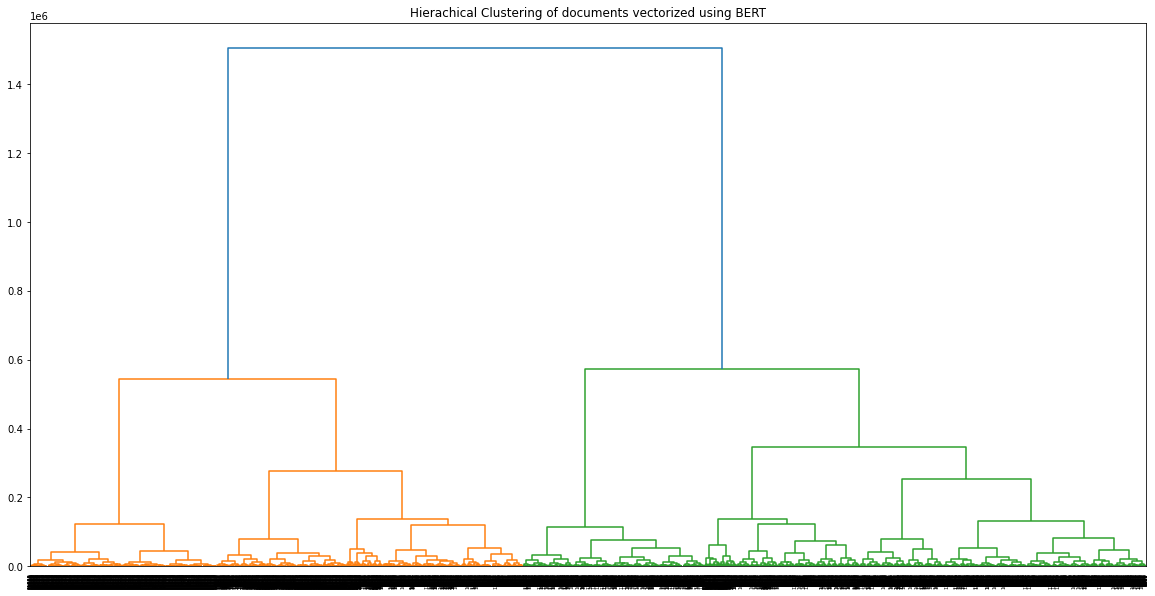

In [49]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

aggclust = AgglomerativeClustering(n_clusters = 2)
aggclust.fit(df_bert_final.drop(columns=['subreddit']))

#print(f'Number of clusters: {aggclust.n_clusters_}')
#print(f'Dendrogram distances: {aggclust.distances_}')

Z = hierarchy.linkage(aggclust.children_, 'ward')

plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z, leaf_rotation=90)
plt.title('Hierachical Clustering of documents vectorized using BERT')

plt.savefig('Charts/12.jpg')

<a id='ac_bert2'></a><font color='lightpurple'> The AC plot can be used to estimate the level of distinction between the 2 subreddits. From the above plot, we see that the blue line is the largest vertical difference, which indicates that there are 2 major clusters. However, we do not know for sure whether these 2 clusters correspond to MST or Zoom. Nevertheless, the plot is useful in telling us that there are 2 distinct clusters. In fact, there could even be sub-clusters.

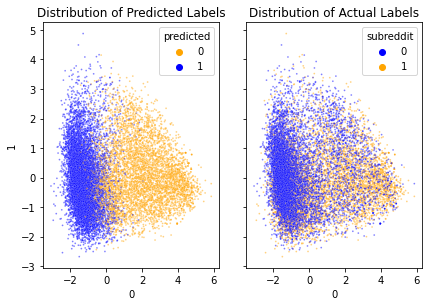

In [62]:
# Visualise the predicted labels vs actual labels, with PCA as dimensionality reduction tool

pca2 = PCA(n_components=2)

pca_features = pd.DataFrame(pca2.fit_transform(df_bert_final.drop(columns=['subreddit'])))
predicted_label = pd.Series(aggclust.labels_, name='predicted')
actual_label = df_bert_final['subreddit']

df_aggclust = pd.concat([pca_features, predicted_label, actual_label], axis=1)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
#fig.suptitle('Reddit content from 1 Jan 2020 onwards', size=20)
plt.tight_layout()
#plt.xticks(rotation=90)

sns.scatterplot(data=df_aggclust, x=0, y=1, hue='predicted', alpha=0.5, ax=ax[0], s=3, 
                palette=['orange', 'blue'])
ax[0].title.set_text('Distribution of Predicted Labels')

sns.scatterplot(data=df_aggclust, x=0, y=1, hue='subreddit', alpha=0.5, ax=ax[1], s=3,
               palette=['blue', 'orange'])
ax[1].title.set_text('Distribution of Actual Labels')

fig.savefig('Charts/17.jpg')

<a id='ac_bert3'></a><font color='lightpurple'> From the above chart, we can see that the separation from AC, although it is able to find 2 clusters, the labels may not necessarily line with the original labels (0 = MST, 1 = Zoom). Based on the distribution pattern though, we can be fairly certain that the model has inverted the labels, since it has no intuition on the original labels. Therefore, we will adjust the color to get a better sense, where class 1 in the AC is class 0 in the original (MST).
    
<font color='lightpurple'> While the AC model has found 2 decent clusters, we see that the original data is alot messier and overlaps much more, which is unsurprising. We can use the AC model to also determine some kind of accuracy score.

In [67]:
pd.crosstab(df_aggclust['predicted'], df_aggclust['subreddit'], normalize=True).round(2)

subreddit,0,1
predicted,,
0,0.14,0.26
1,0.36,0.24


<font color='lightpurple'> Because we have to invert the model classes, we can see that the accuracy is 26%+36% = 62%. This is not a very good score compared to our baseline (see below).

### Further Data Exploration of Vectorized Text (t-SNE)

<a id='tsne1'></a><font color='lightpurple'> One problem text analytics is that it's usually difficult if not impossible to visualise the spread of the data, since the text has been vectorized into so many dimensions (768 for BERT).
    
<font color='lightpurple'> t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique that is capable of dimensionality reduction and hence be able to visualise high dimension data. t-SNE shines over the traditional PCA method as PCA is a linear technique and is hence unable to capture non-linear patterns well, especially in high dimension space [(reference)](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1). Since our vectorized text data is non-linear, t-SNE would be more appropriate as a dimensionality reduction tool.
    
<font color='lightpurple'> That said, a drawback of t-SNE is that unlike PCA, it is not able to "learn" from the data and be used subsequently on unseen data. Hence, we will use t-SNE only for visualisation of text vectors output from BERT and Word2Vec.

In [119]:
from sklearn.manifold import TSNE

# Reduce 770 dimensions from BERT output to 2
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(df_bert_final.drop(['subreddit'],axis=1))

# Include labels
df_tsne = pd.concat([pd.DataFrame(z), df_bert_final['subreddit']], axis=1)
df_tsne['subreddit'] = df_tsne['subreddit'].map({0:'MicrosoftTeams', 1:'Zoom'})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13979 samples in 1.478s...
[t-SNE] Computed neighbors for 13979 samples in 287.559s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13979
[t-SNE] Computed conditional probabilities for sample 2000 / 13979
[t-SNE] Computed conditional probabilities for sample 3000 / 13979
[t-SNE] Computed conditional probabilities for sample 4000 / 13979
[t-SNE] Computed conditional probabilities for sample 5000 / 13979
[t-SNE] Computed conditional probabilities for sample 6000 / 13979
[t-SNE] Computed conditional probabilities for sample 7000 / 13979
[t-SNE] Computed conditional probabilities for sample 8000 / 13979
[t-SNE] Computed conditional probabilities for sample 9000 / 13979
[t-SNE] Computed conditional probabilities for sample 10000 / 13979
[t-SNE] Computed conditional probabilities for sample 11000 / 13979
[t-SNE] Computed conditional probabilities for sample 12000 / 13979
[t-SNE] Computed conditional probabilities for s

In [120]:
# Reduce 300 dimensions from W2V output to 2
tsne2 = TSNE(n_components=2, verbose=1, random_state=123)
z2 = tsne2.fit_transform(np.vstack((w2v_X_train, w2v_X_test)))

# Include labels
df_tsne2 = pd.concat([pd.DataFrame(z2), pd.Series(np.hstack((w2v_y_train, w2v_y_test)))], axis=1)
df_tsne2.columns = [0,1,'subreddit']
df_tsne2['subreddit'] = df_tsne2['subreddit'].map({0:'MicrosoftTeams', 1:'Zoom'})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13936 samples in 0.368s...
[t-SNE] Computed neighbors for 13936 samples in 130.793s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13936
[t-SNE] Computed conditional probabilities for sample 2000 / 13936
[t-SNE] Computed conditional probabilities for sample 3000 / 13936
[t-SNE] Computed conditional probabilities for sample 4000 / 13936
[t-SNE] Computed conditional probabilities for sample 5000 / 13936
[t-SNE] Computed conditional probabilities for sample 6000 / 13936
[t-SNE] Computed conditional probabilities for sample 7000 / 13936
[t-SNE] Computed conditional probabilities for sample 8000 / 13936
[t-SNE] Computed conditional probabilities for sample 9000 / 13936
[t-SNE] Computed conditional probabilities for sample 10000 / 13936
[t-SNE] Computed conditional probabilities for sample 11000 / 13936
[t-SNE] Computed conditional probabilities for sample 12000 / 13936
[t-SNE] Computed conditional probabilities for s

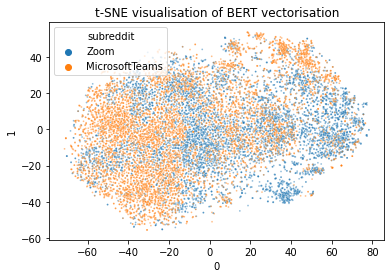

In [121]:
# Visualise t-SNE (BERT)

sns.scatterplot(data=df_tsne, x=0, y=1, hue="subreddit", alpha=0.5, s=3)
plt.title('t-SNE visualisation of BERT vectorisation')
plt.savefig('Charts/13.jpg')

<font color='lightpurple'> From the above chart, we can see that the data is not very well distinguished in 2D space, although there are several noticeable clusters. If this distribution is representative of the actual distribution in multi-dimensional space, then linear classifiers such as Logistic Regression is expected to not perform well if the text is vectorized with BERT.

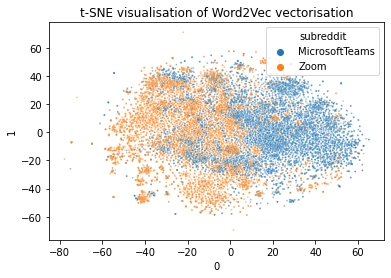

In [122]:
# Visualise t-SNE (W2V)

sns.scatterplot(data=df_tsne2, x=0, y=1, hue="subreddit", alpha=0.5, s=3)
plt.title('t-SNE visualisation of Word2Vec vectorisation')
plt.savefig('Charts/15.jpg')

<font color='lightpurple'> The separation is visibly better when using Word2Vec to vectorize our text, as seen from a clear left half dominated by Zoom and right half dominated by MST. In this case, linear classifiers might do okay, since the boundaries can be defined with a line.

## Modeling

### Baseline Model

<a id='baseline'></a><font color='lightpurple'> The baseline model for this project would be a random classifier, which would predict either class with 50% probability. Thus, the accuracy score for this baseline model would be 50%. Our models should therefore strive to achieve a score significantly better than 50%.    

<font color='lightpurple'> Alternatively, a slightly better model would be to check if Zoom or MST tags are present in the string and classify them as that. In this model, submissions which have both tags would be classified under both.

In [123]:
tfvec_X_test_baseline_zoom = tfvec_X_test.apply(lambda x: 1 if check_word_in_string(x, ['zoom']) else 0)
print(confusion_matrix(y_true=tfvec_y_test, y_pred=tfvec_X_test_baseline_zoom))

[[2236   54]
 [ 791 1533]]


In [124]:
sum(tfvec_X_test_baseline_zoom == tfvec_y_test)/len(tfvec_X_test_baseline_zoom)

0.816861725184222

In [125]:
tfvec_X_test_baseline_mst = tfvec_X_test.apply(lambda x: 0 if check_word_in_string(x, ['microsoft', 'team']) else 1)
print(confusion_matrix(y_true=tfvec_y_test, y_pred=tfvec_X_test_baseline_mst))

[[1727  563]
 [  30 2294]]


In [139]:
sum(tfvec_X_test_baseline_mst == tfvec_y_test)/len(tfvec_X_test_baseline_mst)

0.8714781100996966

<font color='lightpurple'> We can see simply identifying whether the words "microsoft" or "team" are present as the tag, we can achieve an accuracy of 87%, which is very decent given how simple the model is.
    
<font color='lightpurple'> We shall see if our machine learning models can do better than this    

### Model Selection

<a id='model_selection'></a><font color='lightpurple'> We will explore 3 different models - Logistic Regression, MultiLayer Perceptron (MLP) and Random Forest
    
<font color='lightpurple'> **Logistic Regression** assumes a linear relationship between the features and the target variable and converts the output into a value between 0 and 1 via the sigmoid function. It is considered a high bias-low variance model and may work well when the data is of high dimensions, as in our current project.
    
<font color='lightpurple'> **MLP** is a neural network consisting of an input layer, at least 1 hidden layer and an output layer. The neural network method of machine learning was adapted from neurons in the human brain (hence its name), where the brain is made up of many individual neurons linked together. Each neuron takes in an input and generates an output, which may feed to the adjacent neuron, thereby propagating the signal. Likewise, the MLP works by having many neurons (perceptrons) linked together. By adjusting the weights and the output function, the model can be tuned in a way to achieve the desired output. In our project, the desired output would be binary 1 or 0, hence the name MLP Classifier.
    
<font color='lightpurple'> **Random Forest** is made up of many decision trees, where each tree attempts to split the data based on the features. Starting from the full sample, each split involves a boolean question until some sort of stopping threshold is reached, for example, when all the leaves are pure. As expected, individual decision trees are poor learners but data scientists have found that by growing multiple trees and aggregating each tree's predictions, the ensemble model actually does a pretty good job.

In [127]:
lr = LogisticRegression(max_iter=500)
mlp = MLPClassifier(max_iter = 500, random_state=42)
rf = RandomForestClassifier()

tfvec = TfidfVectorizer()
tfvec_X_train_xformed = tfvec.fit_transform(tfvec_X_train)
print(f'Shape of tfvec_X_train_xformed: {tfvec_X_train_xformed.shape}')
tfvec_X_test_xformed = tfvec.transform(tfvec_X_test)
print(f'Shape of tfvec_X_test_xformed: {tfvec_X_test_xformed.shape}')
        
results = []

def trainer(vectorizer, model):
    
    if vectorizer == 'tfvec':
              
        model.fit(tfvec_X_train_xformed, tfvec_y_train)
        train_score = model.score(tfvec_X_train_xformed, tfvec_y_train)
        test_score= model.score(tfvec_X_test_xformed, tfvec_y_test)
        
        return (vectorizer, model, train_score, test_score)

    elif vectorizer == 'w2v':

        model.fit(w2v_X_train, w2v_y_train)
        train_score = model.score(w2v_X_train, w2v_y_train)
        test_score= model.score(w2v_X_test, w2v_y_test)
        
        return (vectorizer, model, train_score, test_score)

    elif vectorizer == 'bert':

        model.fit(bert_X_train, bert_y_train)
        train_score = model.score(bert_X_train, bert_y_train)
        test_score= model.score(bert_X_test, bert_y_test)
        
        return (vectorizer, model, train_score, test_score)    

Shape of tfvec_X_train_xformed: (9365, 15830)
Shape of tfvec_X_test_xformed: (4614, 15830)


In [128]:
for vec in ['tfvec', 'w2v', 'bert']:
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Training LR on {vec} now')
    results.append(trainer(vec, lr))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Training MLP on {vec} now')
    results.append(trainer(vec, mlp))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Training RF on {vec} now')
    results.append(trainer(vec, rf))

13-01-2022 02:49:38: Training LR on tfvec now
13-01-2022 02:49:38: Training MLP on tfvec now
13-01-2022 02:55:24: Training RF on tfvec now
13-01-2022 02:55:32: Training LR on w2v now
13-01-2022 02:55:32: Training MLP on w2v now
13-01-2022 02:56:23: Training RF on w2v now
13-01-2022 02:56:35: Training LR on bert now
13-01-2022 02:56:37: Training MLP on bert now
13-01-2022 02:58:17: Training RF on bert now


In [129]:
df_results = pd.DataFrame(results, columns = ['vectorizer', 'model', 'train_score', 'test_score'])
df_results

,vectorizer,model,train_score,test_score
0,tfvec,LogisticRegression(max_iter=500),0.959851,0.926961
1,tfvec,"MLPClassifier(max_iter=500, random_state=42)",0.998398,0.873212
2,tfvec,"(DecisionTreeClassifier(max_features='auto', r...",0.998719,0.923710
3,w2v,LogisticRegression(max_iter=500),0.905644,0.894325
4,w2v,"MLPClassifier(max_iter=500, random_state=42)",0.997965,0.895195
5,w2v,"(DecisionTreeClassifier(max_features='auto', r...",0.998501,0.856925
6,bert,LogisticRegression(max_iter=500),0.913828,0.899220
7,bert,"MLPClassifier(max_iter=500, random_state=42)",0.999680,0.893801
8,bert,"(DecisionTreeClassifier(max_features='auto', r...",0.999680,0.831383


<a id='untuned'></a><font color='lightpurple'> Based on our initial run where default hyperparameters are used, we have already obtained a relatively good score, with many of our models outperforming our baseline model of 87%, albeit marginally.
    
<font color='lightpurple'> For tfvec, the best model is LogisicRegression, which is also the best out of all. For w2v, the best model is MLP while for bert, the best model is again LogisticRegression.
    
<font color='lightpurple'> Despite its simplicity, LogisticRegression does pretty well. This could be because due to the large number of features, our MLP and RF models overfitted to the data, as seen where the training score is significantly higher than the test score for these 2 models.
    
<font color='lightpurple'> Let's attempt to tune the hyperparameters of our models and see whether there is any change to our results, as a tuned RandomForest or MLP model may perform better than a tuned LogisticRegression model 

### Hyperparameter Tuning

In [130]:
lr_params = {
    'solver': ['saga', 'liblinear', 'lbfgs'],
    'C': [10, 5, 1, 0.1, 0.01]
}

grid_lr = RandomizedSearchCV(LogisticRegression(max_iter=500,random_state=42), param_distributions=lr_params, scoring='accuracy', verbose=1, cv=3, n_iter=20, random_state=42)

rf_params = {
    'n_estimators': [100,125,150],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'log2', None],
    'ccp_alpha': [0.01, 0.1, 0, 10]
}

grid_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=rf_params, scoring='accuracy', verbose=1, cv=3, n_iter=10, random_state=42)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (50,50)],
    'alpha': [0, 0.1, 0.01, 0.001, 0.0001]
}

grid_mlp = RandomizedSearchCV(MLPClassifier(max_iter=500,random_state=42), param_distributions=mlp_params, scoring='accuracy', verbose=1, cv=3, n_iter=5, random_state=42)

In [131]:
results_tuned = []

def hyperparameter_tuner(vectorizer, grid):
    
    if vectorizer == 'tfvec':

        grid.fit(tfvec_X_train_xformed, tfvec_y_train)
        
        return (vectorizer,grid.estimator, grid.best_score_, grid.best_params_) 
    
    elif vectorizer == 'w2v':

        grid.fit(w2v_X_train, w2v_y_train)
        
        return (vectorizer,grid.estimator, grid.best_score_, grid.best_params_) 
    
    elif vectorizer == 'bert':

        grid.fit(bert_X_train, bert_y_train)
        
        return (vectorizer,grid.estimator, grid.best_score_, grid.best_params_) 

In [13]:
for vec in ['tfvec', 'w2v', 'bert']:
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Gridsearching LR on {vec} now')
    results_tuned.append(hyperparameter_tuner(vec, grid_lr))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Gridsearching MLP on {vec} now')
    results_tuned.append(hyperparameter_tuner(vec, grid_mlp))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Gridsearching RF on {vec} now')
    results_tuned.append(hyperparameter_tuner(vec, grid_rf))

In [133]:
df_results_tuned = pd.DataFrame(results_tuned, columns = ['vectorizer', 'model', 'best_score', 'best_params'])
df_results_tuned

,vectorizer,model,best_score,best_params
0,tfvec,"LogisticRegression(max_iter=500, random_state=42)",0.925680,"{'solver': 'saga', 'C': 1}"
1,tfvec,"MLPClassifier(max_iter=500, random_state=42)",0.906887,"{'hidden_layer_sizes': (50,), 'alpha': 0.01}"
2,tfvec,RandomForestClassifier(random_state=42),0.914362,"{'n_estimators': 100, 'min_samples_split': 5, ..."
3,w2v,"LogisticRegression(max_iter=500, random_state=42)",0.891293,"{'solver': 'saga', 'C': 1}"
4,w2v,"MLPClassifier(max_iter=500, random_state=42)",0.895792,"{'hidden_layer_sizes': (100,), 'alpha': 0}"
5,w2v,RandomForestClassifier(random_state=42),0.858412,"{'n_estimators': 100, 'min_samples_split': 2, ..."
6,bert,"LogisticRegression(max_iter=500, random_state=42)",0.887666,"{'solver': 'lbfgs', 'C': 1}"
7,bert,"MLPClassifier(max_iter=500, random_state=42)",0.882541,"{'hidden_layer_sizes': (100,), 'alpha': 0}"
8,bert,RandomForestClassifier(random_state=42),0.832994,"{'n_estimators': 100, 'min_samples_split': 2, ..."


<a id='tuned1'></a><font color='lightpurple'> Because of the large number of permutations, it is computationally expensive to try every combination. Hence, we have adopted RandomizedSearchCV instead of GridSearchCV, where the former will randomly choose a specified number of combination to try.
    
<font color='lightpurple'> Based on our results, we still see that TfidfVectorizer combined with LogisticRegression gives the best result.
    
<font color='lightpurple'> Amongst the vectorizers, Tfidf performs the best. This could possibly be due to the nature of the text where, if we were to vectorise the text according to its meaning and context, both subreddits would give similar results due to the fact that the product is similar to start with. For example, on both subreddits, there would be alot of discussions relating to the features of the product, many of which exist in both. In other text classification problems such as the classic ham vs spam, there is no clear key words that strongly identifies ham or spam, hence models such as BERT, which takes into the account the context of the whole sentence, might do better. Furthermore, BERT and Word2Vec were trained on texts with proper English, and applying them to Reddits, where language is often mashed up, may cause them to not do very well. Hence, Tfidf, which simply counts and weights individual words, might work better for this problem. Nevertheless, the results are still outstanding, at around 80-90%.
    
<font color='lightpurple'> LogisticRegression, despite being the simplest model, consistently outperforms the rest. One reason could be due to the large number of dimensions compared to the number of samples, which is more suited for high-bias low-variance models such as LogisticRegression. Other models might suffer from overfitting, as we saw earlier [here](#untuned).
    
<font color='lightpurple'> Based on our tuning results, we will perform more thorough tuning with LogisticRegression as well as the hyperparameters of TfidfVectorizer. We will also explore whether having the comment statistics will improve our accuracy.

### Further Hyperparameter Tuning for TfidfVectorizer and LogisticRegression

In [14]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),    
    ('lr', LogisticRegression(max_iter=500, random_state=42))                
                ])

params_grid = {
    "tfidf__ngram_range": [(1,1), (1,2), (2,2)],
    "tfidf__max_df": [1.0, 0.95, 0.9],
    "tfidf__min_df": [0, 1, 5],
    "tfidf__max_features": [16000, 13000, 10000, 8000, 1000],
    "lr__penalty": ['l2', 'none'],
    "lr__solver": ['saga', 'lbfgs'],
    "lr__C": [2.5, 1.5, 1, 0.5, 0.1]
}

grid_further = GridSearchCV(pipe, param_grid=params_grid, scoring='accuracy', verbose=0, cv=3)
grid_further.fit(tfvec_X_train, tfvec_y_train)

In [141]:
print(f'Best CV score: {grid_further.best_score_}')
print(f'Best parameters: {grid_further.best_params_}')

Best CV score: 0.9258939890636354
Best parameters: {'lr__C': 0.5, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 1.0, 'tfidf__max_features': 16000, 'tfidf__min_df': 0, 'tfidf__ngram_range': (1, 1)}


<font color='lightpurple'> After 8 hours of tuning, we noted some interesting results diverging from the default parameters:
    
- <font color='lightpurple'> The optimal regularisation strength is 0.5, slightly lower than the default of 1.0. It seems that regularisation does not help much with performance.
- <font color='lightpurple'> The optimal number of features is 16000, which is about the original number of features if only unigrams were used. A limit has to be set on the number of features as not doing so results in memory error where the model attempts to fit > 100,000 features at once.
- <font color='lightpurple'> The minimum document frequency under TfidfVectorizer is 0 as compared to the default of 1. Based on the documentation, it doesn't seem that whether the value of 0 or 1 affects the results, and could simply be chosen at random.
- <font color='lightpurple'> TfidfVectorizer works better when only unigrams are considered. This is interesting, as conjugated words do tend to have very different meaning from individual words (eg. "not good" vs "not" "good"), but perhaps the individual words alone are sufficient to distinguish the subreddits.

### Does Comment Statistics improve results?

In [98]:
def preprocess_tfidf_tuned(dataframe,
                     lower_case=True,
                     remove_special_punc=True,
                     lemmatize=True,
                     ngram_range=(1,1), max_df=1.0, min_df=1, max_features=None):
    '''
    Takes in a dataframe including the text, performs train-test split followed by vectorization
    Default Arguments only applicable for TfidfVectorizer
    '''
    
    # Preprocess text first
    df_tfidf = dataframe[['ids', 'subreddit', 'text_nostop']]
    df_tfidf.columns = ['index_tfidf', 'subreddit', 'text_nostop']
    
    if lower_case:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.lower() #lower case
    
    if remove_special_punc:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation
    
    if lemmatize:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()])) #lemmatize
    
    tfvec = TfidfVectorizer(ngram_range=ngram_range,
                           max_df=max_df,
                           min_df=min_df,
                           max_features=max_features)
    
    tfvec_X_train, tfvec_X_test, tfvec_y_train, tfvec_y_test = train_test_split(df_tfidf[['index_tfidf', 'text_nostop']], df_tfidf['subreddit'],
                                                                                test_size=0.33, random_state=42)

    tfvec_X_train_id = tfvec_X_train['index_tfidf'].reset_index(drop=True)
    
    # Vectorise training text data
    tfvec_X_train_text = tfvec.fit_transform(tfvec_X_train['text_nostop'])
    print(f'Shape of tfidf X_train_text: {tfvec_X_train_text.shape}')
    
    # Save Tfidf model
    pickle.dump(tfvec, open('models/trained_tfidf.sav', 'wb'))

    # Add back in id column, since the order of the rows is the same
    tfvec_X_train_text_id = pd.concat([tfvec_X_train_id, 
               pd.DataFrame(tfvec_X_train_text.todense(), columns=tfvec.get_feature_names())]
              , axis=1)
    print(f'Shape of tfidf X_train_text_id: {tfvec_X_train_text_id.shape}')

    
    # Merge in comment data
    tfvec_X_train_final = tfvec_X_train_text_id.merge(cmts, how='left', left_on = 'index_tfidf', right_on = 'parent_id').drop(columns = ['parent_id'])
    tfvec_X_train_final.fillna(0, inplace=True)
    tfvec_X_train_final.drop(columns='index_tfidf', inplace=True)
    print(f'Shape of tfidf X_train_final: {tfvec_X_train_final.shape}')
    print(f'Shape of tfidf y_train: {tfvec_y_train.shape}')
    
    # Repeat for test text data
    
    tfvec_X_test_id = tfvec_X_test['index_tfidf'].reset_index(drop=True)

    tfvec_X_test_text = tfvec.transform(tfvec_X_test['text_nostop'])
    print(f'Shape of tfidf X_test_text: {tfvec_X_test_text.shape}')

    tfvec_X_test_text_id = pd.concat([tfvec_X_test_id, 
               pd.DataFrame(tfvec_X_test_text.todense(), columns=tfvec.get_feature_names())]
              , axis=1)
    print(f'Shape of tfidf X_test_text_id: {tfvec_X_test_text_id.shape}')

    tfvec_X_test_final = tfvec_X_test_text_id.merge(cmts, how='left', left_on = 'index_tfidf', right_on = 'parent_id').drop(columns = ['parent_id'])
    tfvec_X_test_final.fillna(0, inplace=True)
    tfvec_X_test_final.drop(columns='index_tfidf', inplace=True)
    print(f'Shape of tfidf X_test_final: {tfvec_X_test_final.shape}')
    print(f'Shape of tfidf y_test: {tfvec_y_test.shape}')
    
    return tfvec_X_train_final, tfvec_X_test_final, tfvec_y_train, tfvec_y_test

In [99]:
# Use best params for Tfidf

tfvec_X_train_cmts, tfvec_X_test_cmts, tfvec_y_train_cmts, tfvec_y_test_cmts = preprocess_tfidf_tuned(df,
                                                                                                     ngram_range=(1,1),
                                                                                                     max_df=1.0,
                                                                                                     max_features=16000,
                                                                                                     min_df=0)

<ipython-input-98-47672b35f091>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation


Shape of tfidf X_train_text: (9365, 15830)
Shape of tfidf X_train_text_id: (9365, 15831)
Shape of tfidf X_train_final: (9365, 15832)
Shape of tfidf y_train: (9365,)
Shape of tfidf X_test_text: (4614, 15830)
Shape of tfidf X_test_text_id: (4614, 15831)
Shape of tfidf X_test_final: (4614, 15832)
Shape of tfidf y_test: (4614,)


In [7]:
# Use best params for Logreg

lr_final = LogisticRegression(max_iter=500,
                             C=0.5, 
                              penalty='l2', 
                              solver='saga')

lr_final.fit(tfvec_X_train_cmts, tfvec_y_train_cmts)

print(f'Final training score: {lr_final.score(tfvec_X_train_cmts, tfvec_y_train_cmts)}')
print(f'Final test score: {lr_final.score(tfvec_X_test_cmts, tfvec_y_test_cmts)}')

Final training score: 0.9588894821142552
Final test score: 0.9416991764195926


In [97]:
# save final model

pickle.dump(lr_final, open('models/trained_lr.sav', 'wb'))

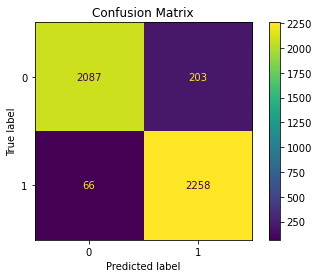

In [8]:
plot_confusion_matrix(lr_final, tfvec_X_test_cmts, tfvec_y_test_cmts)
plt.title('Confusion Matrix')
plt.savefig('Charts/18.jpg')

<a id='model_evaluation'></a><font color='lightpurple'> Our model has performed superbly with an accuracy of 94%. In other words, out of every 100 predictions, it has gotten 94 correct!

In [9]:
df_proba = pd.DataFrame(lr_final.predict_proba(tfvec_X_test_cmts), columns=['MST', 'Zoom'])
df_proba_mst = df_proba['MST']
df_proba_zoom = df_proba['Zoom']

print(f'In predicting MST, it is on average {round(100*df_proba_mst[df_proba_mst >= 0.5].mean())}% confident')
print(f'In predicting Zoom, it is on average {round(100*df_proba_zoom[df_proba_zoom >= 0.5].mean())}% confident')

In predicting MST, it is on average 88% confident
In predicting Zoom, it is on average 84% confident


<font color='lightpurple'> While there is no good benchmark as to whether our confidence score is good or not, we can at least say that the model is more or less robust and confident in its predictions. In other words, it is not "lucky" by chance because it predicts a particular label which happens to be correct, even though it is only 50.1% confident.

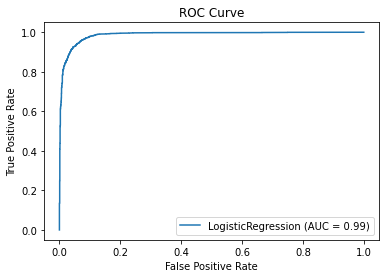

In [12]:
plot_roc_curve(lr_final, tfvec_X_test_cmts, tfvec_y_test_cmts)
plt.title('ROC Curve')
plt.savefig('Charts/19.jpg')

<font color='lightpurple'> The ROC curve is another way to evaluate our model, where scores range from 0 to 1. Scores close to 1 indicate that the model is able to effectively distinguish between the positive and negative classes while scores close to 0.5 indicate that the model has no discriminant ability and works no better than a random number generator. Scores close to 0 are also good, except that the model has inverted its predictions, indicating that there is likely some logic error in the implementing code.

### Putting the results together in charts

<font color='lightpurple'> At the initial phase, we tested a total of 9 combinations arising from 3 vectorizers:

- <font color='lightpurple'> TfidfVectorizer
- <font color='lightpurple'> Word2Vec
- <font color='lightpurple'> BERT    
    
<font color='lightpurple'> and 3 models:
    
- <font color='lightpurple'> LogisticRegression
- <font color='lightpurple'> MultiLayer Perceptron Classifier
- <font color='lightpurple'> RandomForest
    
<font color='lightpurple'> All models were untuned, using default hyperparameters, including the TfidfVectorizer and the results were:
    
<img src="Charts/Untuned.png" style="height: 300px">  

<font color='lightpurple'> We obtained a pretty decent result right off the bat, with scores of 80% or better. The TfidfVectorizer-LogisticRegression combination seemed to work best (93%) and has accuracy 6 pct points higher than the baseline. However, as the difference in performances is small, tuning the models might result in a different outcome. However, from a practical perspective since there were so many combinations of vectorizers, models and hyperparameters to test, we used the RandomizedSearchCV which randomly selects n combinations within the specified space.
    
<img src="Charts/Tuned1.png" style="height: 300px">    
 
<font color='lightpurple'> The results were not comparable to the first graph as cross_val_score was used instead, to avoid data leakage from the hold-out test set. However, it is clear that the TfidfVectorizer-LogisticRegression combination still edges out the rest.

<font color='lightpurple'> With this knowledge, we proceed to further tune this combination, including the the hyperparameters of TfidfVectorizer. We also included the comment statistics as additional features for the model, as prepared earlier. 
    
<img src="Charts/Tuned2.png" style="height: 200px"> 
    
<font color='lightpurple'> With the tuning, we managed to improve accuracy by about 1%.   

### Understanding the final model <a id='understanding_final_model'></a>

In [10]:
# Sort dataframe by size of coefficient

df_coef = pd.DataFrame({'feature': tfvec_X_train_cmts.columns,
              'coefficient': lr_final.coef_[0],
              'exp_coefficient': np.exp(lr_final.coef_[0])}).sort_values('exp_coefficient', ascending=False)

df_coef.head()

,feature,coefficient,exp_coefficient
15774,zoom,12.129529,185262.462355
15830,has_zoom,3.916600,50.229355
7234,host,3.389056,29.637970
8053,join,1.804036,6.074115
10285,participant,1.637768,5.143678


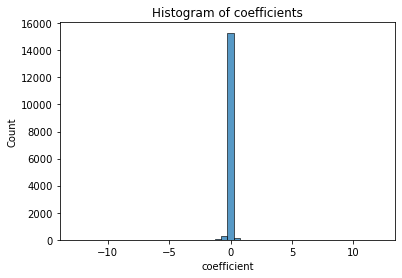

In [11]:
sns.histplot(data=df_coef, x='coefficient', bins=50)
plt.title('Histogram of coefficients')
plt.savefig('Charts/16.jpg')

<font color='lightpurple'> We observe that the vast number of words have little to no impact on the model's predictions, which is expected. However, we do see a slight left skew, indicating that there are more words indicative of MSD as compared to Zoom.

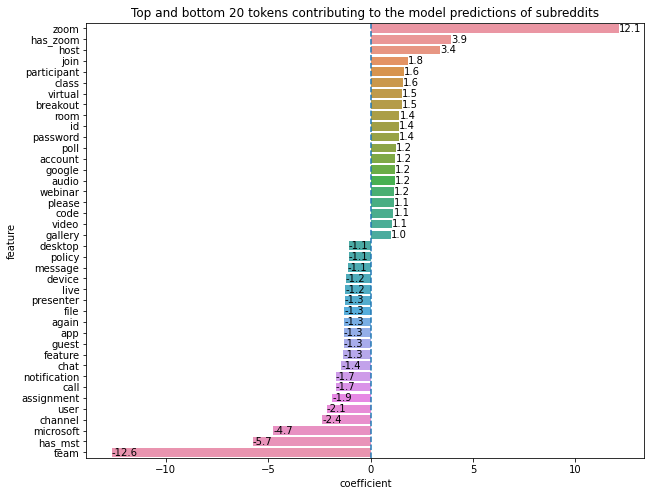

In [12]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=pd.concat([df_coef.head(20), df_coef.tail(20)]), y='feature', x='coefficient')
ax.set_title('Top and bottom 20 tokens contributing to the model predictions of subreddits')
plt.axvline(x=0, ls='--')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 0,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.1f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
    
plt.savefig('Charts/14.jpg')

In [14]:
len(df_coef[df_coef.coefficient >0 ])

7038

<a id='interpret_words'></a><font color='lightpurple'> The coefficients of LogisticRegression measure the degree which the target variable is sensitive to the feature. A larger absolute value of the coefficients implies that the target is more sensitive toward that feature.
    
<font color='lightpurple'> From the above graph, we see that the word "zoom" has the largest coefficient while "team" has the largest negative coefficient. In order to derive meaningful interpretations, one has to first take the exponent of the coefficient. For the word "zoom", that value would be about 4,000,000. In other words, having the presence of this word increases the ratio of success to failure by 4 million times. In the context of our problem, success is defined by classifying the submission as a Zoom subreddit, and is arbitrarily set. Ie. Success could also be defined as MicrosoftTeams and the result would be the same. The graph here was not exponentiated to show the relative comparison of the features; doing so would cause the other features' coefficients to be negligible given that the feature "zoom" is already 4 million.
    
<font color='lightpurple'> Because of the exponent, we say that features with a coefficient larger than 0 will improve the odds of the model predicting Zoom, and features with coefficients less than 0 will improve the odds of the model predicting MST. The blue dotted line depicts this cut off. Interestingly, out of the 16000 features, only 7000 of them, when present, increases the odds of success.
    
<font color='lightpurple'> The coefficients imply that the 2 words "team" and "zoom" are extremely important; this is perhaps unsurprising. Of interest is also the "has_zoom" and "has_mst" features which are essentially summary statistics of the comments. If a larger proportion of comments mention zoom or MST only, then that submission is likely to belong to that category.
    
<font color='lightpurple'> Looking at the top and bottom 20 features, we can observe that most of them are either general, or are not unique to either platform, such as "meeting", "join", "participant", "call". However there are some specific words that stand out:
    
- <font color='lightpurple'> class (Zoom): A virtual classroom product built on top of Zoom
- <font color='lightpurple'> webinar (Zoom): An online seminar product built on top of Zoom, likely similar to MST live event function    
- <font color='lightpurple'> virtual (Zoom): Likely to be in the context of "virtual background". Feature allowing users to customise their background. This feature is also present in MST.
- <font color='lightpurple'> breakout (Zoom): Likely to be in the context of "breakout rooms". Feature allowing the host to split call participants into random or pre-arranged groups, with each group in their own Zoom call. This feature is also present in MST, although it was only introduced in Dec 2020, hence in the period of our data collected, breakout rooms are unique and only avialable to Zoom at that time.   
- <font color='lightpurple'> google (Zoom): Requires further context/exploration
- <font color='lightpurple'> assignment (MST): Feature supporting virtual classrooms, enabling teachers to assign assignments to students.   
- <font color='lightpurple'> channel (MST): Feature allowing threads to be distinguished by topic instead of by people. (From MST website: Channels are dedicated sections within a team to keep conversations organized by specific topics, projects, disciplines)
- <font color='lightpurple'> notification (MST): Requires further context/exploration     
- <font color='lightpurple'> live (MST): Likely to be in the context of "live events". Feature in MST similar to Zoom webinars            
    
<font color='lightpurple'> Let's explore some of these words and see examples of their appearances to get some better context   

In [13]:
# Top 10 submissions with the word "google"
tfvec_X_train.iloc[tfvec_X_train_cmts[tfvec_X_train_cmts['google'] != 0]['google'].sort_values(ascending=False).head(10).index].values

array(['sign google', 'google meet', 'google meet call',
       'join google meet',
       'google calendar hijacking zoom meeting adding google meet button',
       'join google meet class',
       'hello everyone simple way allow u create team meeting google calendar could something similar calendly appointment app book google outlook event time generate team meeting link want use team alternative meet still book google thank advance schedule team meeting google calendar',
       'schedule team meeting google calendar', 'google meet bomb',
       'new microsoft team add google calendar'], dtype=object)

<font color='lightpurple'> Seems like there is a substantial amount of discussion within the Zoom chat mentioning Google in the context of Google meet. Other than soliciting for participants for Google meet, people also discussed about features in Google meet that are similar in Zoom.

In [158]:
# Top 10 submissions with the word "notification"
tfvec_X_train.iloc[tfvec_X_train_cmts[tfvec_X_train_cmts['notification'] != 0]['notification'].sort_values(ascending=False).head(10).index].values

array(['participant notification', 'got notification',
       'keep getting notification every time someone say something meeting chat incredibly annoying gone notification setting turned every notification option could notification still appearing turn off meeting notification',
       'got many notification saying testing notification microsoft investigate problem anyone else facing issue even got notification saying test notification afternoon fcm message notification',
       'please help turn notification off getting notification chat already looking realtime notification stack obscure chat box im trying use ive scoured setting turned notification nothing worked',
       'hi guy 1 notification showing team seem clear anybody issue searched notification find triggering this notification disappear activity',
       'turn channel notification team',
       'owner team turn channel notification turn channel notification everyone else team setting per person question channel notificati

<font color='lightpurple'> Notification is a feature unique to MST that alerts the user about ongoing activities. Seems that people are concerned with issues surrounding this feature.

### Explore what are users talking about

In [71]:
# Top 10 submissions with the word "breakout"
tfvec_X_train.iloc[tfvec_X_train_cmts[tfvec_X_train_cmts['breakout'] != 0]['breakout'].sort_values(ascending=False)[10:25:2].index].values

array(['hi wondering teacher see chat breakout room thanks advance question breakout room chat',
       'create breakout room ipad', 'zoom spotlight breakout room',
       'question title need multiple breakout room operating time also participant trickling throughout day want able move people main room breakout room without first emptying breakout room way achieve zoom way empty individual breakout room without emptying breakout room',
       'possibility start breakout room use team linux breakout room linux',
       'someone explain create breakout room ipad mobile device breakout room mobile',
       'hello everyone know per session pre assigned breakout room used use pre assigned breakout room twice mean ill move people assigned breakout room main room assigned breakout room thanks urgent question breakout room',
       'room people people new update allows switch breakout room individual member update allowed switch breakout room also zoom io android allow people switch breakout 

In [76]:
# Top 10 submissions with the word "gallery"
tfvec_X_train.iloc[tfvec_X_train_cmts[tfvec_X_train_cmts['gallery'] != 0]['gallery'].sort_values(ascending=False)[:10].index].values

array(['gallery view tip',
       'im participant m team meeting change meeting view gallery large gallery change everyone me',
       'hi two issue getting trouble employer please help can 1 today screen sharing participant gallery view gallery suddenly disappeared retrieve checked hide gallery enabled stopped screen sharing gallery reappeared disappeared shared 2 way people breakout room see screen sharing thank you help wanna get fired',
       'host possible make everyone see gallery view host possible make everyone see gallery view',
       'using gallery view cloud recording zoom record view host ie order people asking know gallery view differs participant gallery view recording view',
       'hello want record lecture 77 people gallery view able see every individual face recording not live lecture fraction people gallery view recording cheer revording gallery view',
       'hey guy zoom gallery view wonder order videospeople determined doesnt seem maybe it determined joining tim

### Exploring Misclassifications

In [234]:
df_misclass = pd.DataFrame({'predictions':lr_final.predict(tfvec_X_test_cmts), 
                            'true': tfvec_y_test_cmts, 
                            'probability': lr_final.predict_proba(tfvec_X_test_cmts)[:,1]
                           })

# Keep only misclassified rows
df_misclass = df_misclass[df_misclass['predictions'] != df_misclass['true']]

# Merge in original text
df_misclass = df_misclass.merge(tfvec_X_test[df_misclass[df_misclass['predictions'] != df_misclass['true']].index], how='left', left_index=True, right_index=True)

In [240]:
pd.set_option('display.max_colwidth', None)

df_misclass.sample(6)

,predictions,true,probability,text_nostop
640,0,1,0.467682,hi schedule recurring meeting phone app show online account anyone know sync these tia app sync
9965,1,0,0.835560,please help camera hidden share screen participant get bored
10197,1,0,0.815036,aspect ratiorequirements virtual background
4410,0,1,0.480724,sit window left side table take call face look like halfmoon one side lighted side lighted course could shift 90 degree face window need refer desktop pc time make sense keep alternating window back pc every time take video call idea one problem thought getting ring light seem many option webcam ring light even ring light seem good enough illuminate face compensate uneven lighting deal uneven lighting taking video call
7775,1,0,0.510970,suggestion good way prevent student cheating multiple choice form quiz example failing student finish difficult physic quiz 7 second score 100 something definitely i give openended question would like make testing process somewhat manageable right cheating
479,0,1,0.425665,mute presenter shared sound presenter know shared sound


<a id='misclassification'></a><font color='lightpurple'> Let's explore 6 random rows misclassified, out of the 269 misclassified entries. As TfidfVectorizer looks out for keywords, if keywords for that subreddit are present, it would probably classify it as such, however, if no keywords are present, it might not make a confident guess.
    
<font color='lightpurple'> Row 640: There aren't really any keywords here from either subreddit, hence although the prediction was MST, the model's confidence is only 46%.
    
<font color='lightpurple'> Row 9965: Here, the model is very confident that it is from a Zoom reddit, probably due to the word "participant". However, this is a general word that one can easily use it in either context, hence we can see why the model misclassifies, in the absence of other words.
    
<font color='lightpurple'> Row 10197: Similarly, to row 9965, the model picks up on the word "virtual" and confidently (and wrongly) predicts Zoom, though virtual backgrounds are a feature common to both.
    
<font color='lightpurple'> Row 4410, 7775 and 479: There is quite a large chunk of text here but there are no really strong keywords, hence the model can only make a somewhat random guess.    

<font color='lightpurple'> As we can see, there are limitations to the TfidfVectorizer where once it has identified a word to be strongly correlated with a certain class, it will tend to predict submissions with that word as that class, if no other strong keywords are present. This causes some degree of misclassification, but we are still pleased with the overall accuracy of 94%.
    
<font color='lightpurple'> BERT, on the other hand, might be able to do better in such circumstances due to its ability to interpret the entire context as opposed to picking up only specific keywords. However, due to the nature of reddit posts where language is often disregarded, it might be difficult for BERT to pick up "internet lingo", as it was trained on texts with proper English.    

##### Is text data successfully converted to a matrix representation?

<font color='lightpurple'> Yes, we have successfully vectorized the text with 3 methods - TfidfVectorizer, Word2Vec and BERT

##### Are methods such as stop words, stemming, and lemmatization explored?

<font color='lightpurple'> Yes, in our explanation [(here)](#advanced_text_cleaning), we discussed why different text preprocessing techniques are required for different vectorizers.

##### Does the student properly split and/or sample the data for validation/training purposes?

<font color='lightpurple'> Yes, for convenience of scripting and data flow, we may have incorporated the train-test-split step differently for each vectorizing technique. Though, all of them have the same random_state and split size, which would result in the split being identical for all our models to ensure consistency. Stratified splits are not required as our target classes are balanced.

##### Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: Random Forest and one other model)?

<font color='lightpurple'> Yes, we experimented with 3 models - RandomForestClassifier, MultiLayerPerceptron Classifier and LogisticRegression. See [here](#model_selection)

##### Does the student defend their choice of production model relevant to the data at hand and the problem?

<font color='lightpurple'> Yes, we chose LogisticRegression combined with TfidfVectorizer in the end due to its best accuracy score - it is able to make the most number of correct predictions. Other advantages of this model (happy coincidence) is that it is the most explainable out of the 3, runs the fastest and does not suffer from overfitting.

##### Does the student explain how the model works and evaluate its performance successes/downfalls?

<font color='lightpurple'> Our model performs the best likely due to its simplicity (high bias low variance) in the presence of many features. Other models tended to overfit the data which resulted in poor performance in unseen cases. Given our already high performance baseline model of 87%, it is unsurprising that TfidfVectorizer performs the best, which simply counting words would be better than trying to decipher the sentence's meaning, which in the context of Reddit posts, is often incoherent. Also see [here](#tuned1).
    
<font color='lightpurple'> We also looked at cases of misclassifications and attempted to reason why the model may have misclassified ([see here](#misclassification)) 

# Evaluation & Conceptual Understanding

##### Does the student accurately identify and explain the baseline score?

<font color='lightpurple'> See [here](#baseline)

##### Does the student select and use metrics relevant to the problem objective?

<font color='lightpurple'> See [here](#problem_statement)

##### Does the student interpret the results of their model for purposes of inference?

<font color='lightpurple'> See [this section](#understanding_final_model) for model interpretation

##### Is domain knowledge demonstrated when interpreting results?

<font color='lightpurple'> See [here](#interpret_words). Here, we evaluated the model's most significant words and made a judgment as to which words are worth investigating further and why are certain words identified.

##### Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?

<font color='lightpurple'> All cells with statistical outputs have accompanying descriptions and inferences

# Conclusions & Recommendations

<a id='recommendation'></a><font color='lightpurple'> We have successfully trained a LogisticRegression model to predict a post's subreddit with 94% accuracy by first vectorizing the text using TfidfVectorizer.
    
<font color='lightpurple'> Using the model's coefficients, we identified top words that would result in the model predicting either class. Some of these words are generic and provide no further information (eg. team, zoom), while others may provide some insight as to what the general population thinks. We have also performed deeper dives into these words to have a better sense on why users are talking about it. Based on top submissions for the keywords, we have developed recommendations for the SDT and MT.
    
<font color='lightpurple'> **Recommendations for SDT:**
    
- <font color='lightpurple'> [On breakout rooms] Allowing host to create breakout rooms via mobile devices eg. iPad
- <font color='lightpurple'> [On breakout rooms] Allowing reassignment of participants to breakout rooms without first closing the rooms
- <font color='lightpurple'> [On breakout rooms] Allowing host to pre-assign multiple rounds of breakout rooms    
- <font color='lightpurple'> [On gallery view] More functionalities around gallery view eg. sharing gallery view with participants, ordering of gallery frames, filling empty spaces within gallery view, allow gallery view when session is recorded 
- <font color='lightpurple'> Given that notifications are a major pain point for MST users, ensure that the notifications settings in the Zoom interface is as intuitive and comprehensive as possible.    

<font color='lightpurple'> Improving our platform features will provide a more pleasant and seamless experience for users and win more users over to our side. This will lead to an increase in our revenue when more companies subscribe to our usage plans.    
    
<font color='lightpurple'> **Recommendations for MT:**    
    
- <font color='lightpurple'> Use the top 20 words closely associated with Zoom (eg. host, join, participant, class, virtual) in our Search Engine Marketing and Search Engine Optimisation campaigns.
- <font color='lightpurple'> Utilise these words as paid keywords such as Google AdWords or organic keywords in our sites.    
    
<font color='lightpurple'> By knowing the "lingo" that our users employ when discussing about our product, we can provide more targeted help to users when they use this "lingo" to search for our product. Buying out Google AdWords can also direct more users to our platform and expand our marketing reach.    

<font color='lightpurple'> In terms of future work, we would like to explore the following areas:
- <font color='lightpurple'> Updating the dataset with more recent submissions to see if there are differences in content. Since our dataset is 1 year ago, updates, patches and new features would have been introduced by both platforms.
- <font color='lightpurple'> Further training the BERT model with our dataset to update its ability to recognize "Reddit" lingo, which may differ from the standard English it has been pre-trained on.

##### Does the student provide appropriate context to connect individual steps back to the overall project?

<font color='lightpurple'> Yes, the steps are all undertaken with the final goal of constructing a robust model which can give us a sense of what is being discussed on both subreddits.

##### Is it clear how the final recommendations were reached?

<font color='lightpurple'> See [here](#recommendation)

##### Are the conclusions/recommendations clearly stated?

<font color='lightpurple'> See [here](#recommendation)

##### Does the conclusion answer the original problem statement?

<font color='lightpurple'> See [here](#recommendation)

##### Does the student address how findings of this research can be applied for the benefit of stakeholders?

<font color='lightpurple'> See [here](#recommendation)

##### Are future steps to move the project forward identified?

<font color='lightpurple'> See [here](#recommendation)